## Load Dataset

In [1]:
# Data Handling and Manipulation
import pandas as pd
import numpy as np
import os

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from wordcloud import WordCloud

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Clustering Evaluation Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
import warnings

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [3]:
eda_data = pd.read_csv(
    "C:\\Users\\shiri\\OneDrive\\Documents\\Python\\ml-projects\\data-606\\pharmaceutical-drug-price-prediction\\data\\processed\\model_drug_amp.csv")
eda_data2 = pd.read_csv(
    "C:\\Users\\shiri\\OneDrive\\Documents\\Python\\ml-projects\\data-606\\pharmaceutical-drug-price-prediction\\data\\interim\\drug_amp_dataset.csv")

## Basic Exploration

In [4]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726104 entries, 0 to 726103
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   product_group                       726104 non-null  int64  
 1   ingredient                          726104 non-null  object 
 2   strength                            726104 non-null  object 
 3   dosage                              726104 non-null  object 
 4   route                               726104 non-null  object 
 5   mdr_unit_type                       726104 non-null  object 
 6   weighted_average_of_amps            726104 non-null  float64
 7   aca_ful                             726104 non-null  float64
 8   package_size                        726104 non-null  float64
 9   ndc                                 726104 non-null  object 
 10  year                                726104 non-null  int64  
 11  month                     

In [5]:
print("Drug Data Shape:", eda_data.shape)

Drug Data Shape: (726104, 30)


In [6]:
# Print column names for drug_data DataFrame
print(eda_data.columns)

Index(['product_group', 'ingredient', 'strength', 'dosage', 'route',
       'mdr_unit_type', 'weighted_average_of_amps', 'aca_ful', 'package_size',
       'ndc', 'year', 'month', 'strength_num', 'strength_ratio', 'gnrc_name',
       'tot_mftr', 'tot_spndng', 'tot_clms', 'tot_benes', 'tot_dsg_unts',
       'avg_spnd_per_dsg_unt_wghtd', 'avg_spnd_per_clm', 'avg_spnd_per_bene',
       'month_sin', 'month_cos', 'tot_mftr_avg_spnd_per_bene',
       'tot_mftr_tot_benes', 'avg_spnd_per_clm_avg_spnd_per_bene',
       'avg_dsg_units_per_clm', 'utilization_rate'],
      dtype='object')


In [7]:
eda_data.nunique()

product_group                          1147
ingredient                              415
strength                                335
dosage                                   86
route                                    13
mdr_unit_type                             7
weighted_average_of_amps              48725
aca_ful                               45888
package_size                            114
ndc                                   32903
year                                      5
month                                    12
strength_num                            114
strength_ratio                           81
gnrc_name                               415
tot_mftr                                 44
tot_spndng                             1786
tot_clms                               1756
tot_benes                              1711
tot_dsg_unts                           1784
avg_spnd_per_dsg_unt_wghtd             1744
avg_spnd_per_clm                       1785
avg_spnd_per_bene               

## 3. Clustering Drugs by Pricing Behavior


To group drugs based on their pricing trends and key characteristics, we experimented with multiple clustering techniques—standard K-Means, a custom K-Means implementation with basic distance metrics, and hierarchical (bottom-up / top-down view) methods. Each approach was evaluated using cluster quality metrics such as WCSS, Silhouette Score, and Davies-Bouldin Score. Additionally, PCA visualizations were used to interpret cluster separation and cohesion. After comparing results across all methods and features, we selected the clustering solution that best captured meaningful patterns in drug behavior, offering a reliable basis for further analysis of price dynamics and group-specific vulnerabilities.

### 3.1 Feature Selection


In [8]:
features = ['gnrc_name','weighted_average_of_amps','strength',
            'tot_mftr','tot_spndng', 'tot_dsg_unts', 'tot_clms', 'tot_benes',
            'avg_spnd_per_dsg_unt_wghtd', 'avg_spnd_per_clm', 'avg_spnd_per_bene']

df_model = eda_data[features].dropna()  # Drop missing values

In [9]:
df_model.head()

gnrc_name  weighted_average_of_amps    strength  \
0  irbesartan/hydrochlorothiazide                   0.40976  150-12.5mg   
1  irbesartan/hydrochlorothiazide                   0.40976  150-12.5mg   
2  irbesartan/hydrochlorothiazide                   0.40976  150-12.5mg   
3  irbesartan/hydrochlorothiazide                   0.40976  150-12.5mg   
4  irbesartan/hydrochlorothiazide                   0.40976  150-12.5mg   

   tot_mftr  tot_spndng  tot_dsg_unts  tot_clms  tot_benes  \
0 -0.642857   -0.383572     -0.245444 -0.340344  -0.248539   
1 -0.642857   -0.383572     -0.245444 -0.340344  -0.248539   
2 -0.642857   -0.383572     -0.245444 -0.340344  -0.248539   
3 -0.642857   -0.383572     -0.245444 -0.340344  -0.248539   
4 -0.642857   -0.383572     -0.245444 -0.340344  -0.248539   

   avg_spnd_per_dsg_unt_wghtd  avg_spnd_per_clm  avg_spnd_per_bene  
0                   -0.111208         -0.043815          -0.041168  
1                   -0.111208         -0.043815          -0.041168  
2                   -0.111208         -0.043815          -0.041168  
3                   -0.111208         -0.043815          -0.041168  
4                   -0.111208         -0.043815          -0.041168

### 3.2 Aggregate data

In [10]:
# Grouping by Drug Name
summary = df_model.groupby("gnrc_name").agg(
    unique_strength_count=("strength", lambda x: x.nunique()),
    total_unique_mftr=("tot_mftr", lambda x: sum(set(x))),
    min_weighted_amp = ("weighted_average_of_amps", "min"),
    max_weighted_amp = ("weighted_average_of_amps","max"),
    mean_weighted_amp = ("weighted_average_of_amps","mean"),
    std_weighted_amp = ("weighted_average_of_amps","std"),
    min_spending=("tot_spndng", "min"),
    max_spending=("tot_spndng", "max"),
    mean_spending=("tot_spndng", "mean"),
    std_spending=("tot_spndng", "std"),
    min_claims=("tot_clms", "min"),
    max_claims=("tot_clms", "max"),
    mean_claims=("tot_clms", "mean"),
    std_claims=("tot_clms", "std"),
    min_benes=("tot_benes", "min"),
    max_benes=("tot_benes", "max"),
    mean_benes=("tot_benes", "mean"),
    std_benes=("tot_benes", "std"),
    min_dosage_units=("tot_dsg_unts", "min"),
    max_dosage_units=("tot_dsg_unts", "max"),
    mean_dosage_units=("tot_dsg_unts", "mean"),
    std_dosage_units=("tot_dsg_unts", "std"),
).reset_index()


summary.head()

gnrc_name  unique_strength_count  total_unique_mftr  \
0             abacavir sulfate                      1          -0.714286   
1  abacavir sulfate/lamivudine                      1          -0.857143   
2          abiraterone acetate                      1           0.214286   
3          acamprosate calcium                      1          -0.785714   
4                     acarbose                      3          -0.928571   

   min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0          0.428450          5.081903           1.803262          1.280726   
1          2.837262         86.001593          15.261870         13.282889   
2          3.168927         29.992580          12.788470          6.311937   
3          0.127410          0.975534           0.560315          0.198422   
4         -0.189023          0.389429           0.038095          0.131510   

   min_spending  max_spending  mean_spending  ...  mean_claims  std_claims  \
0     -0.446660     -0.427158      -0.437531  ...    -0.408583    0.000835   
1     -0.429567     -0.367248      -0.405265  ...    -0.408531    0.001179   
2      3.041556      3.612366       3.289946  ...    -0.387384    0.002543   
3     -0.455561     -0.445113      -0.450072  ...    -0.408039    0.000476   
4     -0.443435     -0.429197      -0.436068  ...    -0.391884    0.001291   

   min_benes  max_benes  mean_benes  std_benes  min_dosage_units  \
0  -0.315408  -0.313508   -0.314568   0.000653         -0.326108   
1  -0.315391  -0.312431   -0.314329   0.001007         -0.328142   
2  -0.303177  -0.299833   -0.301670   0.001352         -0.292646   
3  -0.312019  -0.310593   -0.311355   0.000511         -0.319478   
4  -0.296889  -0.296280   -0.296578   0.000260         -0.287717   

   max_dosage_units  mean_dosage_units  std_dosage_units  
0         -0.323543          -0.324585          0.000954  
1         -0.326995          -0.327681          0.000464  
2         -0.283008          -0.288141          0.003909  
3         -0.315518          -0.317481          0.001446  
4         -0.274609          -0.280381          0.005532  

[5 rows x 23 columns]

In [11]:
clustering_df = summary.copy()

In [12]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gnrc_name              415 non-null    object 
 1   unique_strength_count  415 non-null    int64  
 2   total_unique_mftr      415 non-null    float64
 3   min_weighted_amp       415 non-null    float64
 4   max_weighted_amp       415 non-null    float64
 5   mean_weighted_amp      415 non-null    float64
 6   std_weighted_amp       415 non-null    float64
 7   min_spending           415 non-null    float64
 8   max_spending           415 non-null    float64
 9   mean_spending          415 non-null    float64
 10  std_spending           415 non-null    float64
 11  min_claims             415 non-null    float64
 12  max_claims             415 non-null    float64
 13  mean_claims            415 non-null    float64
 14  std_claims             415 non-null    float64
 15  min_be

In [13]:
num_features1 = clustering_df.select_dtypes(include=['int64', 'float64']).columns

X = clustering_df[num_features1].values

## 4. KElbow - Finding Optimal K

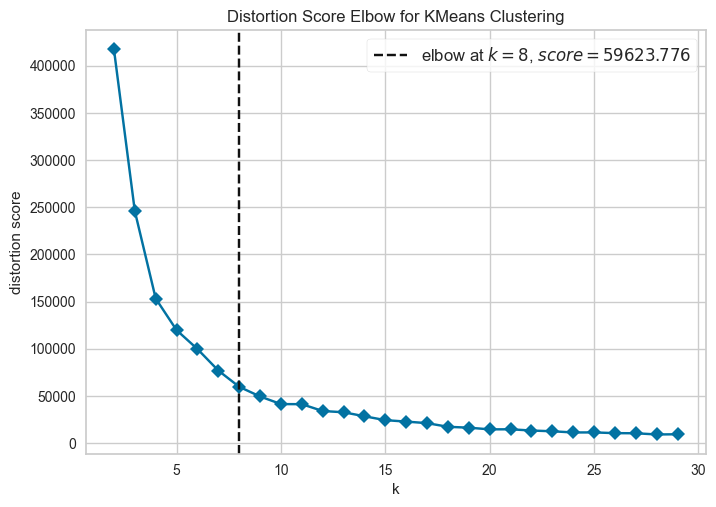

In [14]:
model = KMeans() # Elbow method applied with the usual Euclidean metric

visualizer = KElbowVisualizer(model, k=(2,30), timings=False)
visualizer.fit(X)
visualizer.show()
plt.show()

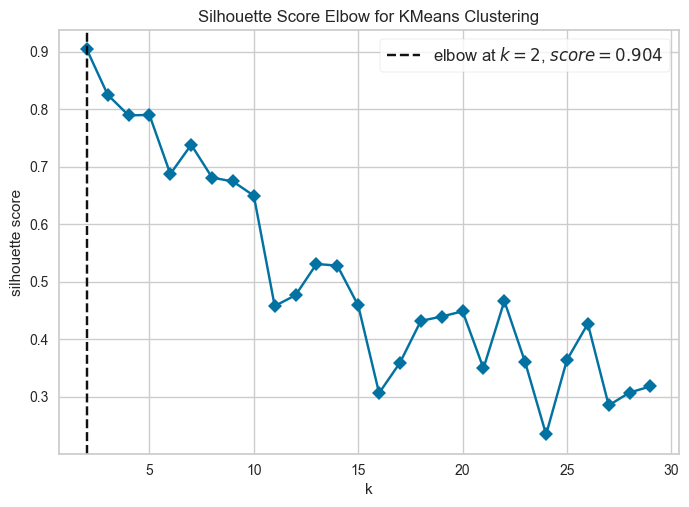

In [15]:
# Applying the Silhouette score
visualizer = KElbowVisualizer(model, k=(2,30), metric = 'silhouette' ,timings=False)
visualizer.fit(X)
visualizer.show()
plt.show()

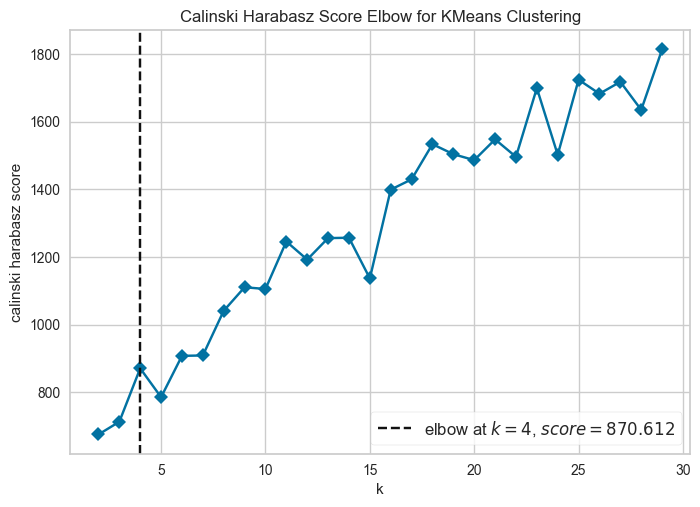

In [16]:
# Applying the Calinski-Harabasz score
visualizer = KElbowVisualizer(model, k=(2,30), metric = 'calinski_harabasz', timings=False)
visualizer.fit(X)
visualizer.show()
plt.show()

### 4.1 Elbow Method & KElbowVisualizer


**Testing different K values using WCSS and visualizing PCA projections**


In [17]:
def kmeans_clusters(X, n_clust, visualize=True):
    X = np.array(X)

    # Fit K-Means
    k_means = KMeans(n_clusters=n_clust, random_state=42)
    y_pred = k_means.fit_predict(X)
    cl_centroids = k_means.cluster_centers_

    # Calculate Silhouette Score
    score = silhouette_score(X, y_pred)
    print(f"Silhouette Score for k={n_clust}: {score:.4f}")

    # Visualization using PCA
    if visualize:
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        centroids_reduced = pca.transform(cl_centroids)

        plt.figure(figsize=(6, 4))
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='viridis', s=25)
        plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c='red', s=100, marker="x")
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'K-Means Clustering with PCA (k={n_clust})')
        plt.show()

    return cl_centroids, score

Silhouette Score for k=8: 0.7012


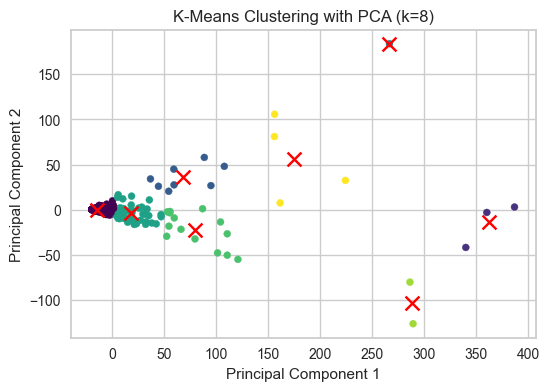

(array([[ 2.53134328e+00, -3.30277186e-01,  2.84866298e-01,
          3.89745683e+00,  1.14456120e+00,  7.23347409e-01,
         -1.27096747e-01, -9.32422865e-03, -7.74864078e-02,
          4.11699636e-02, -9.55758585e-02, -2.90246438e-02,
         -5.98392897e-02,  2.35423504e-02,  2.52058454e-02,
          1.00431689e-01,  6.33730181e-02,  2.66872769e-02,
          1.85696042e-02,  1.06318809e-01,  6.81652478e-02,
          3.07686704e-02],
        [ 2.66666667e+00, -6.66666667e-01,  3.22880086e+01,
          3.38410313e+02,  1.60894016e+02,  7.67568626e+01,
          3.29545717e-01,  1.11038363e+00,  5.40826241e-01,
          2.29048799e-01, -3.97006239e-01, -3.92258156e-01,
         -3.94277026e-01,  1.78279344e-03, -3.05318085e-01,
         -3.02434605e-01, -3.03699167e-01,  1.12854288e-03,
         -3.25986549e-01, -3.25379994e-01, -3.25662766e-01,
          2.19025599e-04],
        [ 1.00000000e+00, -7.67857143e-01,  4.17546345e+01,
          6.60681339e+01,  5.20676985e+01,  7.

In [18]:
kmeans_clusters(X, 8)

Silhouette Score for k=5: 0.7385


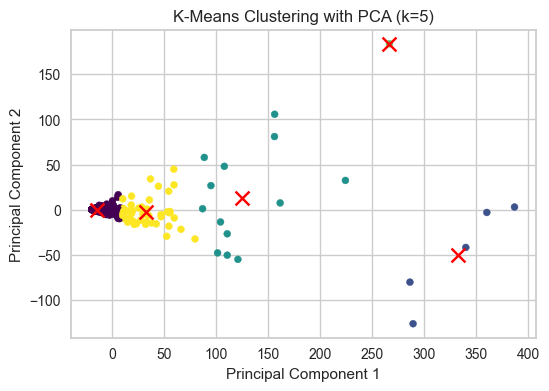

(array([[ 2.54441261e+00, -3.36266885e-01,  4.04886783e-01,
          4.65608341e+00,  1.37290159e+00,  8.51996742e-01,
         -1.06338336e-01,  1.76479563e-02, -5.51360859e-02,
          4.35283890e-02, -1.05407944e-01, -4.06222041e-02,
         -7.06125262e-02,  2.29196583e-02,  1.47133407e-02,
          8.79558340e-02,  5.19224323e-02,  2.59862340e-02,
          7.26899913e-03,  9.23679027e-02,  5.53303778e-02,
          2.98594935e-02],
        [ 2.80000000e+00,  1.42857143e-02,  2.11484059e+01,
          3.31912116e+02,  1.08574241e+02,  6.32481559e+01,
          6.34017099e-02,  5.45263177e-01,  1.98275656e-01,
          1.42254970e-01, -3.58955343e-01, -3.54368731e-01,
         -3.56305888e-01,  1.68425871e-03, -2.47497350e-01,
         -2.42735660e-01, -2.45132496e-01,  1.84497033e-03,
         -2.81010549e-01, -2.71760737e-01, -2.75625114e-01,
          3.28738349e-03],
        [ 1.84615385e+00, -1.42857143e-01,  3.59003737e+01,
          1.25411870e+02,  5.97296666e+01,  1.

In [19]:
kmeans_clusters(X, 5)

Silhouette Score for k=2: 0.8807


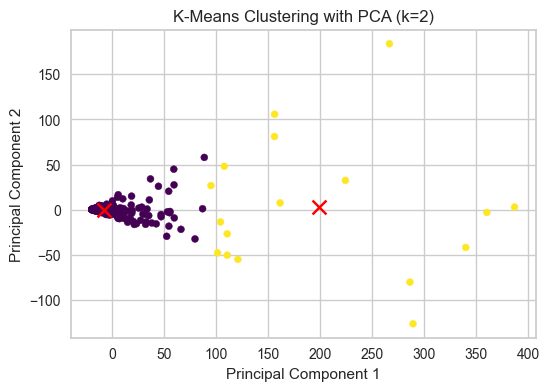

(array([[ 2.56532663e+00, -3.23761665e-01,  1.39047799e+00,
          1.01326321e+01,  3.50375898e+00,  1.82452755e+00,
         -9.95392524e-02,  3.00235717e-02, -4.57502940e-02,
          4.54151780e-02, -1.28081838e-01, -6.76801185e-02,
         -9.57204321e-02,  2.12776678e-02, -1.10693487e-02,
          5.88103659e-02,  2.42034375e-02,  2.46241347e-02,
         -2.04924459e-02,  5.85700309e-02,  2.42790216e-02,
          2.76721536e-02],
        [ 2.17647059e+00, -5.04201681e-02,  4.05840914e+01,
          1.95093988e+02,  8.25468871e+01,  3.15733102e+01,
          1.69736051e-01,  4.92639860e-01,  2.64998565e-01,
          9.25416873e-02, -1.34015616e-01, -1.08117235e-01,
         -1.19228735e-01,  8.69982438e-03, -4.96854687e-02,
         -8.66901697e-03, -2.65688143e-02,  1.40282316e-02,
          1.34491162e-01,  2.46782732e-01,  2.07541801e-01,
          3.74646102e-02]]),
 0.8806995019852625)

In [20]:
kmeans_clusters(X, 2)

In [21]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_df[num_features1])

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")


Explained variance ratio: [0.88982957 0.09242291]
Total explained variance: 0.98


### 4.2 Evaluation Metrics for K = 2, 5, 6, 8, 12

In [22]:
k_values = [8,6,12,5,3,2]
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_df[num_features1])
    print(f'WCSS for k={k}: {kmeans.inertia_}')


WCSS for k=8: 60732.35427718683
WCSS for k=6: 104531.66908343506
WCSS for k=12: 34837.8275449708
WCSS for k=5: 127685.51917344463
WCSS for k=3: 252682.36329679
WCSS for k=2: 427737.4070992527


In [23]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(clustering_df[num_features1])
    score = silhouette_score(clustering_df[num_features1], labels)
    print(f'Silhouette Score for k={k}: {score}')


Silhouette Score for k=8: 0.701245471346575
Silhouette Score for k=6: 0.7393260262910681
Silhouette Score for k=12: 0.6388382441604524
Silhouette Score for k=5: 0.7385325273959686
Silhouette Score for k=3: 0.825191296803335
Silhouette Score for k=2: 0.8806995019852625


In [24]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(clustering_df[num_features1])
    score = davies_bouldin_score(clustering_df[num_features1], labels)
    print(f'Davies-Bouldin Score for k={k}: {score}')


Davies-Bouldin Score for k=8: 0.6411763531037353
Davies-Bouldin Score for k=6: 0.582731375812745
Davies-Bouldin Score for k=12: 0.6402720355218036
Davies-Bouldin Score for k=5: 0.6415818706590326
Davies-Bouldin Score for k=3: 0.619571796783574
Davies-Bouldin Score for k=2: 0.6345590021720295



- k=2 and k=3 show stronger statistical separation, they group drugs too broadly to capture meaningful pricing patterns. In contrast, k=8 strikes the right balance between statistical validity and interpretability. It offers compact clusters (low WCSS), reasonable separation (Silhouette = 0.70), and distinct grouping (DB Score = 0.64).
- This makes k=8 more effective for analyzing drug price behavior, as it reveals nuanced groupings that align with real-world usage, cost, and regulatory patterns — critical for identifying trends, vulnerabilities, and policy targets.

##  5. K-Means Clustering

### 5.1 Traditional K-Means (Euclidean Distance)

In [25]:
# Run K-Means and get cluster labels
n_clusters = 8
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(clustering_df[num_features1])

clustering_df["drug_cluster"] = k_means.fit_predict(clustering_df[num_features1])  # Exclude drug names if in first column

clustering_df.head()

gnrc_name  unique_strength_count  total_unique_mftr  \
0             abacavir sulfate                      1          -0.714286   
1  abacavir sulfate/lamivudine                      1          -0.857143   
2          abiraterone acetate                      1           0.214286   
3          acamprosate calcium                      1          -0.785714   
4                     acarbose                      3          -0.928571   

   min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0          0.428450          5.081903           1.803262          1.280726   
1          2.837262         86.001593          15.261870         13.282889   
2          3.168927         29.992580          12.788470          6.311937   
3          0.127410          0.975534           0.560315          0.198422   
4         -0.189023          0.389429           0.038095          0.131510   

   min_spending  max_spending  mean_spending  ...  std_claims  min_benes  \
0     -0.446660     -0.427158      -0.437531  ...    0.000835  -0.315408   
1     -0.429567     -0.367248      -0.405265  ...    0.001179  -0.315391   
2      3.041556      3.612366       3.289946  ...    0.002543  -0.303177   
3     -0.455561     -0.445113      -0.450072  ...    0.000476  -0.312019   
4     -0.443435     -0.429197      -0.436068  ...    0.001291  -0.296889   

   max_benes  mean_benes  std_benes  min_dosage_units  max_dosage_units  \
0  -0.313508   -0.314568   0.000653         -0.326108         -0.323543   
1  -0.312431   -0.314329   0.001007         -0.328142         -0.326995   
2  -0.299833   -0.301670   0.001352         -0.292646         -0.283008   
3  -0.310593   -0.311355   0.000511         -0.319478         -0.315518   
4  -0.296280   -0.296578   0.000260         -0.287717         -0.274609   

   mean_dosage_units  std_dosage_units  drug_cluster  
0          -0.324585          0.000954             1  
1          -0.327681          0.000464             2  
2          -0.288141          0.003909             4  
3          -0.317481          0.001446             1  
4          -0.280381          0.005532             1  

[5 rows x 24 columns]

In [26]:
# Count of each cluster
cluster_counts = clustering_df['drug_cluster'].value_counts().sort_index()
cluster_counts

drug_cluster
0      2
1    336
2     14
3      1
4     47
5      8
6      3
7      4
Name: count, dtype: int64

### 5.2 Custom K-Means (Initial Implementation)

In [27]:
# Distance metric functions
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def chebyshev_distance(a, b):
    return np.max(np.abs(a - b))

def minkowski_distance(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1 / p)


# Custom KMeans implementation
class CustomKMeans:
    def __init__(self, n_clusters=8, max_iter=300, metric="euclidean", p=3, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.metric = metric
        self.p = p  # Minkowski parameter
        self.random_state = random_state
        self.cluster_centers_ = None
        # Compute WCSS (Inertia)
    def calculate_wcss(self, X, cluster_assignments, centers):
        wcss = 0
        for k in range(self.n_clusters):
            points_in_cluster = X[cluster_assignments == k]
            wcss += np.sum((points_in_cluster - centers[k]) ** 2)
        return wcss

    def fit_predict(self, X):
        np.random.seed(self.random_state)

        # Initialize cluster centers randomly
        centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # Compute distances (vectorized)
            if self.metric == "euclidean":
                distances = np.sqrt(((X[:, np.newaxis, :] - centers) ** 2).sum(axis=2))
            elif self.metric == "manhattan":
                distances = np.abs(X[:, np.newaxis, :] - centers).sum(axis=2)
            elif self.metric == "chebyshev":
                distances = np.max(np.abs(X[:, np.newaxis, :] - centers), axis=2)
            elif self.metric == "minkowski":
                distances = ((np.abs(X[:, np.newaxis, :] - centers) ** self.p).sum(axis=2)) ** (1 / self.p)
            else:
                raise ValueError("Unsupported metric: " + self.metric)

            # Assign clusters
            cluster_assignments = np.argmin(distances, axis=1)

            # Update centers (handle empty clusters)
            new_centers = np.zeros_like(centers)
            for k in range(self.n_clusters):
                if np.sum(cluster_assignments == k) == 0:
                    new_centers[k] = X[np.random.randint(0, X.shape[0])]  # Re-initialize randomly
                else:
                    new_centers[k] = X[cluster_assignments == k].mean(axis=0)

            # Check convergence
            if np.allclose(centers, new_centers, atol=1e-5):
                break
            centers = new_centers

        self.cluster_centers_ = centers
        return cluster_assignments


# Unsupervised data
# Apply custom KMeans with different metrics
kmeans_euclidean = CustomKMeans(n_clusters, metric="euclidean")
labels_euclidean = kmeans_euclidean.fit_predict(X)
clustering_df["k_drug_cluster_euclidean"] = labels_euclidean

kmeans_manhattan = CustomKMeans(n_clusters, metric="manhattan")
labels_manhattan = kmeans_manhattan.fit_predict(X)
clustering_df["k_drug_cluster_manhattan"] = labels_manhattan

kmeans_chebyshev = CustomKMeans(n_clusters, metric="chebyshev")
labels_chebyshev = kmeans_chebyshev.fit_predict(X)
clustering_df["k_drug_cluster_chebyshev"] = labels_chebyshev

kmeans_minkowski = CustomKMeans(n_clusters, metric="minkowski", p=3)
labels_minkowski = kmeans_minkowski.fit_predict(X)
clustering_df["k_drug_cluster_minkowski"] = labels_minkowski


clustering_df.head()


gnrc_name  unique_strength_count  total_unique_mftr  \
0             abacavir sulfate                      1          -0.714286   
1  abacavir sulfate/lamivudine                      1          -0.857143   
2          abiraterone acetate                      1           0.214286   
3          acamprosate calcium                      1          -0.785714   
4                     acarbose                      3          -0.928571   

   min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0          0.428450          5.081903           1.803262          1.280726   
1          2.837262         86.001593          15.261870         13.282889   
2          3.168927         29.992580          12.788470          6.311937   
3          0.127410          0.975534           0.560315          0.198422   
4         -0.189023          0.389429           0.038095          0.131510   

   min_spending  max_spending  mean_spending  ...  std_benes  \
0     -0.446660     -0.427158      -0.437531  ...   0.000653   
1     -0.429567     -0.367248      -0.405265  ...   0.001007   
2      3.041556      3.612366       3.289946  ...   0.001352   
3     -0.455561     -0.445113      -0.450072  ...   0.000511   
4     -0.443435     -0.429197      -0.436068  ...   0.000260   

   min_dosage_units  max_dosage_units  mean_dosage_units  std_dosage_units  \
0         -0.326108         -0.323543          -0.324585          0.000954   
1         -0.328142         -0.326995          -0.327681          0.000464   
2         -0.292646         -0.283008          -0.288141          0.003909   
3         -0.319478         -0.315518          -0.317481          0.001446   
4         -0.287717         -0.274609          -0.280381          0.005532   

   drug_cluster  k_drug_cluster_euclidean  k_drug_cluster_manhattan  \
0             1                         5                         2   
1             2                         3                         1   
2             4                         2                         4   
3             1                         5                         5   
4             1                         5                         5   

   k_drug_cluster_chebyshev  k_drug_cluster_minkowski  
0                         1                         1  
1                         3                         3  
2                         7                         4  
3                         5                         5  
4                         5                         5  

[5 rows x 28 columns]

### 5.3 Custom K-Means Evaluation (PCA + Metrics)

In [28]:
# Count clusters for Euclidean
print("Euclidean Cluster Counts:")
print(clustering_df['k_drug_cluster_euclidean'].value_counts().sort_index())

# Count clusters for Manhattan
print("\nManhattan Cluster Counts:")
print(clustering_df['k_drug_cluster_manhattan'].value_counts().sort_index())

# Count clusters for Chebyshev
print("\nChebyshev Cluster Counts:")
print(clustering_df['k_drug_cluster_chebyshev'].value_counts().sort_index())

# Count clusters for Minkowski
print("\nMinkowski Cluster Counts:")
print(clustering_df['k_drug_cluster_minkowski'].value_counts().sort_index())


Euclidean Cluster Counts:
k_drug_cluster_euclidean
0     12
1     88
2     32
3     16
4     19
5    224
6      7
7     17
Name: count, dtype: int64

Manhattan Cluster Counts:
k_drug_cluster_manhattan
0      4
1     22
2    149
3      6
4     42
5    180
6      5
7      7
Name: count, dtype: int64

Chebyshev Cluster Counts:
k_drug_cluster_chebyshev
0      4
1    119
2     46
3     12
4     23
5    172
6      5
7     34
Name: count, dtype: int64

Minkowski Cluster Counts:
k_drug_cluster_minkowski
0     12
1     88
2     46
3     23
4     36
5    183
6      7
7     20
Name: count, dtype: int64


In [29]:
# Calculate WCSS
labels_euclidean = kmeans_euclidean.fit_predict(X)
wcss_euclidean = kmeans_euclidean.calculate_wcss(X, labels_euclidean, kmeans_euclidean.cluster_centers_)
print(f"WCSS (Euclidean): {wcss_euclidean}")

labels_manhattan = kmeans_manhattan.fit_predict(X)
wcss_manhattan = kmeans_manhattan.calculate_wcss(X, labels_manhattan, kmeans_manhattan.cluster_centers_)
print(f"WCSS (Manhattan): {wcss_manhattan}")

labels_chebyshev = kmeans_chebyshev.fit_predict(X)
wcss_chebyshev = kmeans_chebyshev.calculate_wcss(X, labels_chebyshev, kmeans_chebyshev.cluster_centers_)
print(f"WCSS (Chebyshev): {wcss_chebyshev}")

labels_minkowski = kmeans_minkowski.fit_predict(X)
wcss_minkowski = kmeans_minkowski.calculate_wcss(X, labels_minkowski, kmeans_minkowski.cluster_centers_)
print(f"WCSS (Minkowski): {wcss_minkowski}")


WCSS (Euclidean): 151270.77393996582
WCSS (Manhattan): 87527.78314716759
WCSS (Chebyshev): 96987.67781857068
WCSS (Minkowski): 153770.91850979667


In [30]:
# Cluster label columns for each metric
cluster_labels = {
    "Euclidean": "k_drug_cluster_euclidean",
    "Manhattan": "k_drug_cluster_manhattan",
    "Chebyshev": "k_drug_cluster_chebyshev",
    "Minkowski": "k_drug_cluster_minkowski"
}

# Loop through and print scores
for name, col in cluster_labels.items():
    print(f"\n--- {name} Distance ---")
    print(f"Silhouette Score: {silhouette_score(X, clustering_df[col]):.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(X, clustering_df[col]):.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X, clustering_df[col]):.4f}")



--- Euclidean Distance ---
Silhouette Score: 0.4280
Davies-Bouldin Score: 0.9871
Calinski-Harabasz Score: 374.9734

--- Manhattan Distance ---
Silhouette Score: 0.3088
Davies-Bouldin Score: 0.9359
Calinski-Harabasz Score: 690.3947

--- Chebyshev Distance ---
Silhouette Score: 0.3030
Davies-Bouldin Score: 1.0645
Calinski-Harabasz Score: 617.3845

--- Minkowski Distance ---
Silhouette Score: 0.3423
Davies-Bouldin Score: 0.9905
Calinski-Harabasz Score: 367.9314



- Manhattan Distance resulted in the lowest WCSS (best compactness) and the highest Calinski-Harabasz Score, indicating well-separated, dense clusters.

- Euclidean Distance had the highest Silhouette Score, suggesting relatively better cluster separation, but its WCSS and CH scores were weaker.

- Chebyshev and Minkowski performed worse on all scores, especially on Davies-Bouldin (higher = worse) and Silhouette (lower = worse).

Manhattan Distance is the preferred choice for this dataset because it provides the most compact clusters (lowest WCSS) and best cluster density and separation (highest CH score), which is important for pricing-related behavioral segmentation in drugs. Even though its Silhouette Score is slightly lower, the overall structure of clusters is more coherent.

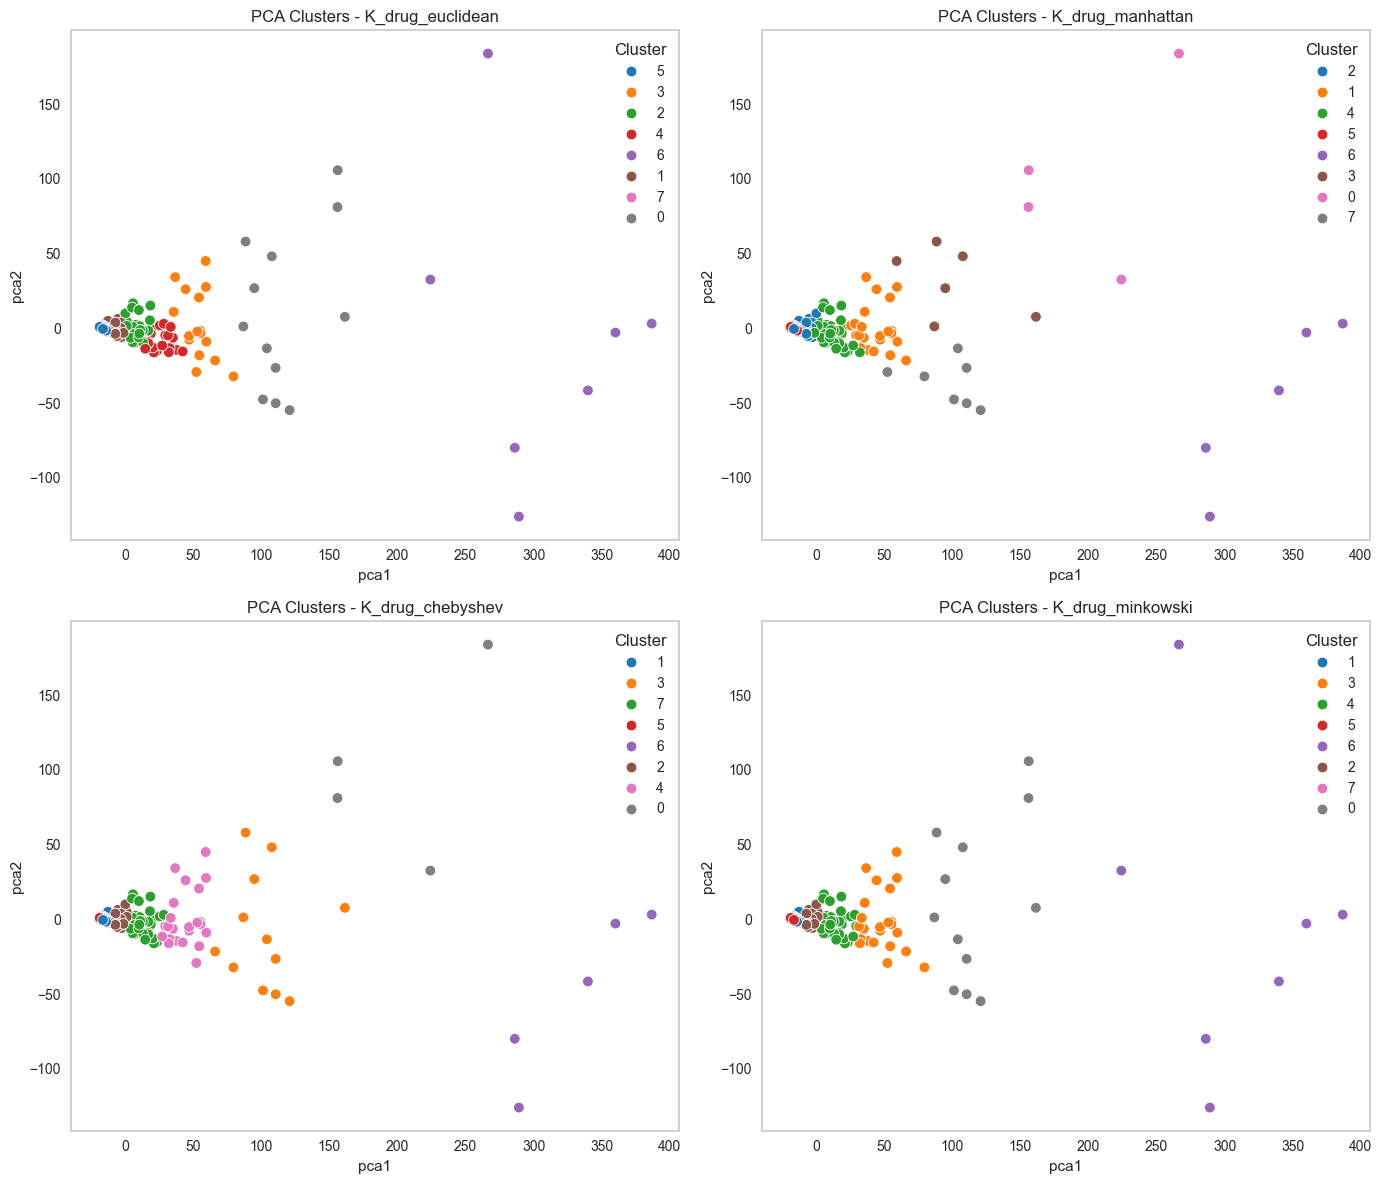

In [31]:
X1 = clustering_df[num_features1]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X1)

clustering_df['pca1'] = pca_result[:, 0]
clustering_df['pca2'] = pca_result[:, 1]



metrics = ['k_drug_cluster_euclidean', 'k_drug_cluster_manhattan', 'k_drug_cluster_chebyshev', 'k_drug_cluster_minkowski']

fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    sns.scatterplot(
        data=clustering_df,
        x='pca1', y='pca2',
        hue=clustering_df[metric].astype(str),
        palette='tab10',
        ax=axs[i],
        s=60
    )
    axs[i].set_title(f'PCA Clusters - {metric.replace("cluster_", "").capitalize()}')
    axs[i].legend(title='Cluster', loc='best')
    axs[i].grid(False)

plt.tight_layout()
plt.show()


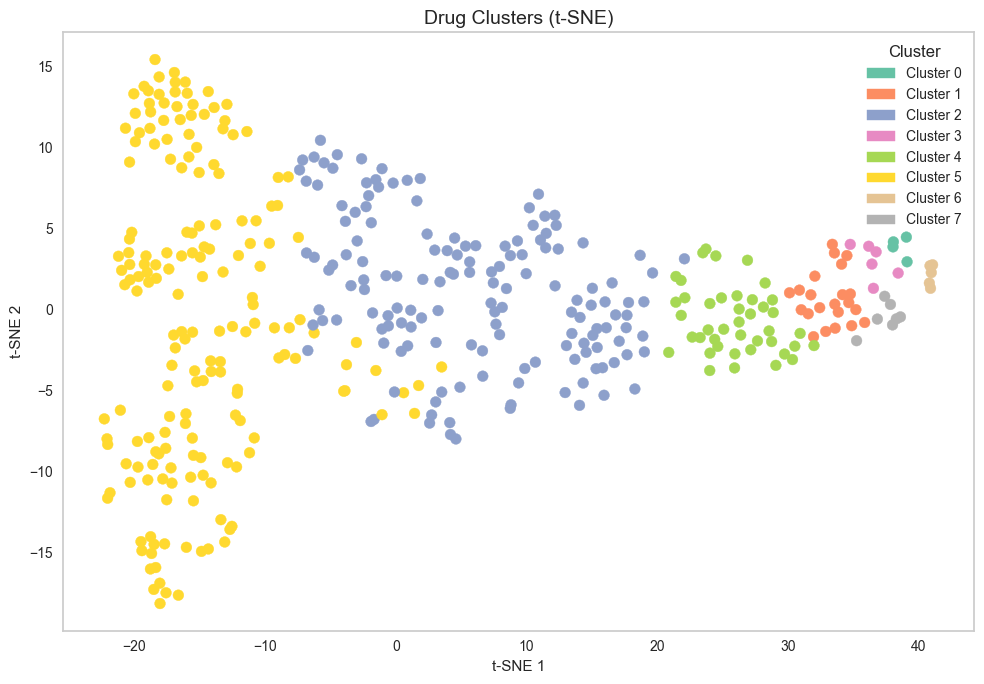

In [32]:
# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X1)

# Prepare cluster labels
cluster_labels = clustering_df["k_drug_cluster_manhattan"]
unique_labels = sorted(cluster_labels.unique())

# Create scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap="Set2", s=60)

plt.title("Drug Clusters (t-SNE)", fontsize=14)
plt.grid(False)

# Add legend manually
handles = [
    mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f"Cluster {label}")
    for label in unique_labels
]
plt.legend(handles=handles, title="Cluster", loc="best")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

### 5.4 Custom K-Means (Optimized Version)

In [33]:
class OptimizedKMeans:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, metric="euclidean", p=3, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol  # Tolerance for convergence
        self.metric = metric
        self.p = p  # Minkowski parameter
        self.random_state = random_state
        self.cluster_centers_ = None
        self.inertia_ = None  # WCSS (Within-Cluster Sum of Squares)

    def _compute_distances(self, X, centers):
        # Compute distances based on the specified metric
        if self.metric == "euclidean":
            return np.sqrt(((X[:, np.newaxis, :] - centers) ** 2).sum(axis=2))
        elif self.metric == "manhattan":
            return np.abs(X[:, np.newaxis, :] - centers).sum(axis=2)
        elif self.metric == "chebyshev":
            return np.max(np.abs(X[:, np.newaxis, :] - centers), axis=2)
        elif self.metric == "minkowski":
            return ((np.abs(X[:, np.newaxis, :] - centers) ** self.p).sum(axis=2)) ** (1 / self.p)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

    def _initialize_centroids(self, X):
        # KMeans++ Initialization
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Randomly select the first centroid
        centroids = [X[np.random.randint(n_samples)]]

        # Select the remaining centroids
        for _ in range(1, self.n_clusters):
            # Compute distances from the existing centroids
            distances = np.min(self._compute_distances(X, np.array(centroids)), axis=1)
            probabilities = distances ** 2
            probabilities /= probabilities.sum()
            cumulative_probs = np.cumsum(probabilities)
            r = np.random.rand()

            # Select the next centroid
            for i, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(X[i])
                    break

        return np.array(centroids)

    def fit_predict(self, X):
        # Initialize centroids using KMeans++
        centers = self._initialize_centroids(X)

        for _ in range(self.max_iter):
            # Step 1: Compute distances and assign clusters
            distances = self._compute_distances(X, centers)
            cluster_assignments = np.argmin(distances, axis=1)

            # Step 2: Update centroids
            new_centers = np.zeros_like(centers)
            for k in range(self.n_clusters):
                points_in_cluster = X[cluster_assignments == k]
                if len(points_in_cluster) == 0:
                    # Handle empty cluster deterministically
                    new_centers[k] = centers[k]
                else:
                    new_centers[k] = points_in_cluster.mean(axis=0)

            # Step 3: Check for convergence
            if np.allclose(centers, new_centers, atol=self.tol):
                break
            centers = new_centers

        # Final step: Compute WCSS (inertia)
        self.cluster_centers_ = centers
        self.inertia_ = np.sum((self._compute_distances(X, centers).min(axis=1)) ** 2)
        return cluster_assignments


In [34]:
# Perform clustering with Euclidean distance
kmeans_euclidean = OptimizedKMeans(n_clusters=8, metric="euclidean", random_state=42)
labels_euclidean = kmeans_euclidean.fit_predict(X)
clustering_df["optimized_kmeans_euclidean"] = labels_euclidean

# Perform clustering with Manhattan distance
kmeans_manhattan = OptimizedKMeans(n_clusters=8, metric="manhattan", random_state=42)
labels_manhattan = kmeans_manhattan.fit_predict(X)
clustering_df["optimized_kmeans_manhattan"] = labels_manhattan

# Compare results
clustering_df.head()


gnrc_name  unique_strength_count  total_unique_mftr  \
0             abacavir sulfate                      1          -0.714286   
1  abacavir sulfate/lamivudine                      1          -0.857143   
2          abiraterone acetate                      1           0.214286   
3          acamprosate calcium                      1          -0.785714   
4                     acarbose                      3          -0.928571   

   min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0          0.428450          5.081903           1.803262          1.280726   
1          2.837262         86.001593          15.261870         13.282889   
2          3.168927         29.992580          12.788470          6.311937   
3          0.127410          0.975534           0.560315          0.198422   
4         -0.189023          0.389429           0.038095          0.131510   

   min_spending  max_spending  mean_spending  ...  std_dosage_units  \
0     -0.446660     -0.427158      -0.437531  ...          0.000954   
1     -0.429567     -0.367248      -0.405265  ...          0.000464   
2      3.041556      3.612366       3.289946  ...          0.003909   
3     -0.455561     -0.445113      -0.450072  ...          0.001446   
4     -0.443435     -0.429197      -0.436068  ...          0.005532   

   drug_cluster  k_drug_cluster_euclidean  k_drug_cluster_manhattan  \
0             1                         5                         2   
1             2                         3                         1   
2             4                         2                         4   
3             1                         5                         5   
4             1                         5                         5   

   k_drug_cluster_chebyshev  k_drug_cluster_minkowski       pca1       pca2  \
0                         1                         1 -13.895154   0.182422   
1                         3                         3  65.915429 -21.491227   
2                         7                         4  13.857921  -1.139254   
3                         5                         5 -18.263197   0.878637   
4                         5                         5 -19.053997   0.522312   

   optimized_kmeans_euclidean  optimized_kmeans_manhattan  
0                           0                           0  
1                           3                           1  
2                           4                           1  
3                           0                           0  
4                           0                           0  

[5 rows x 32 columns]

In [35]:
# Display WCSS (Inertia)
print(f"WCSS (Euclidean): {kmeans_euclidean.inertia_}")
print(f"WCSS (Manhattan): {kmeans_manhattan.inertia_}")

WCSS (Euclidean): 96483.97681184337
WCSS (Manhattan): 279882.4993203444


In [36]:
# Count clusters for Euclidean
print("Euclidean Cluster Counts:")
print(clustering_df['optimized_kmeans_euclidean'].value_counts().sort_index())

# Count clusters for Manhattan
print("\nManhattan Cluster Counts:")
print(clustering_df['optimized_kmeans_manhattan'].value_counts().sort_index())

Euclidean Cluster Counts:
optimized_kmeans_euclidean
0    327
1      7
2      5
3     19
4     45
5      4
6      2
7      6
Name: count, dtype: int64

Manhattan Cluster Counts:
optimized_kmeans_manhattan
0    327
1     43
2     20
3      7
4      3
5      4
6      2
7      9
Name: count, dtype: int64


In [37]:
# Cluster label columns for each metric
cluster_labels2 = {
    "Euclidean": "optimized_kmeans_euclidean",
    "Manhattan": "optimized_kmeans_manhattan"
}

# Loop through and print scores
for name, col in cluster_labels2.items():
    print(f"\n--- {name} Distance ---")
    print(f"Silhouette Score: {silhouette_score(X, clustering_df[col]):.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(X, clustering_df[col]):.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X, clustering_df[col]):.4f}")



--- Euclidean Distance ---
Silhouette Score: 0.6577
Davies-Bouldin Score: 0.7691
Calinski-Harabasz Score: 620.9112

--- Manhattan Distance ---
Silhouette Score: 0.3969
Davies-Bouldin Score: 0.7662
Calinski-Harabasz Score: 804.0559



Optimized KMeans Strengths:
- Higher Silhouette Scores and lower Davies-Bouldin for Euclidean distance show that clusters are more well-separated and internally coherent.

- Euclidean optimized KMeans has significantly better overall performance than custom.

- Manhattan optimized KMeans has very high Calinski-Harabasz, indicating tight and well-defined clusters, but very poor WCSS, suggesting high intra-cluster variation.

**Why Custom KMeans with Manhattan Distance Is Valuable**

Although Optimized KMeans (Euclidean) shows stronger overall clustering metrics, Custom KMeans with Manhattan stands out for domain-specific value, especially in drug pricing:

Key Strengths:
- Lowest WCSS (87,527): Most compact clusters — ideal for grouping similar pricing behaviors.

- Competitive CH Score (690.39): Strong cluster separation, even without full optimization.

- Real-World Fit: Manhattan handles non-linear, skewed, and cost-sensitive features better than Euclidean.

Trade-Off:
- Slightly lower Silhouette and Davies-Bouldin scores, but acceptable when compactness and interpretability matter more than perfect separation.


While Optimized KMeans (Euclidean) outperforms on technical metrics, Custom KMeans with Manhattan distance offers a practically useful, interpretable alternative when working with real-world data like drug pricing:

- Manhattan-Based KMeans Delivers:
 - Lower WCSS (compact clusters)

 - Competitive CH score (good structure)

 - Better handling of non-linear or abrupt feature changes

- Domain-aligned behavior (important in financial or healthcare datasets)

**Why Manhattan Works Better Than Euclidean Here:**
- Euclidean is best used when features are evenly scaled & normally distributed. It assumes all price-related features contribute equally and follow a symmetric distribution — not always true in healthcare pricing.
- Manhattan is best used when features are skewed, sparse, or not uniformly scaled. Manhattan respects the additive nature of cost differences and handles large differences in a single feature without overpowering others — making it more stable and interpretable for drug price clustering.


## 6. Hierarchical Clustering




Can experiment with either agglomerative clustering(bottom-up) approach or by creating flat clusters wirth fclsuters(top down view) with results the same.

### 6.1 Agglomerative Clustering (Bottom-Up)





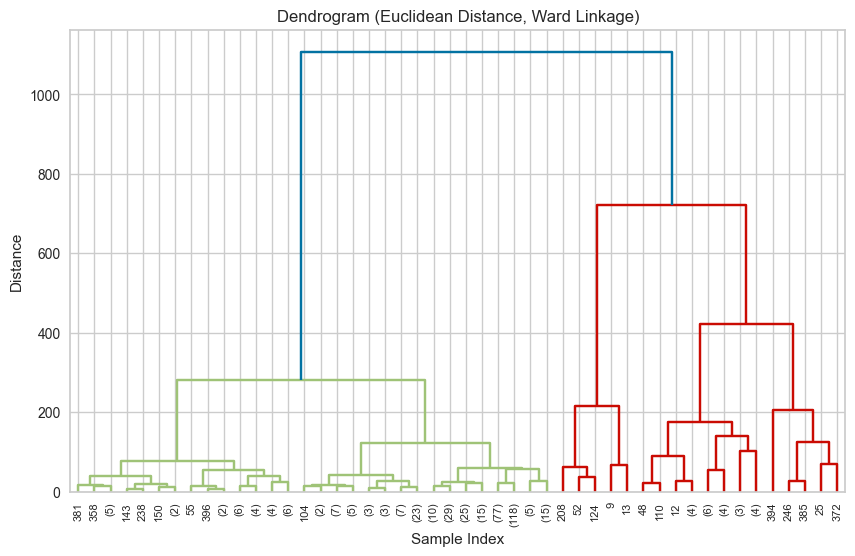

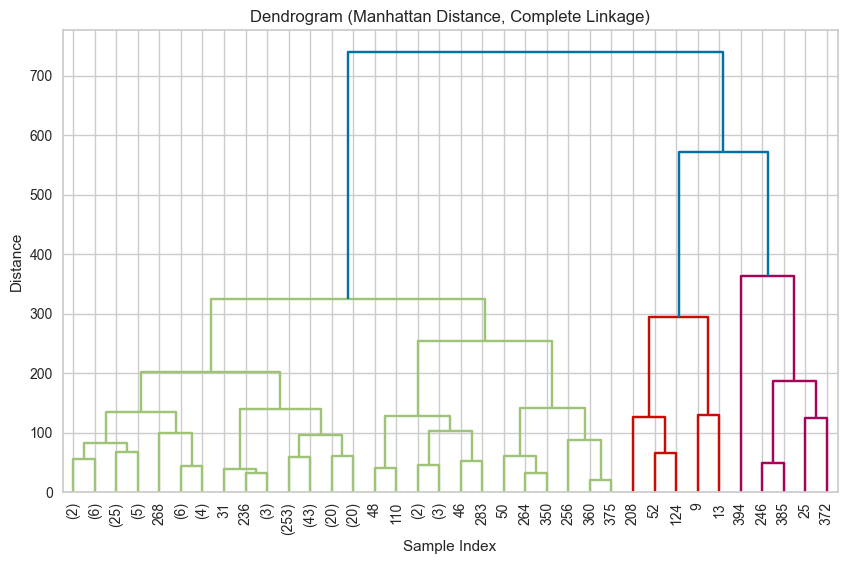

In [38]:
#n_clusters = 8

# Perform Agglomerative Clustering for different metrics
# Ward linkage ONLY works with Euclidean distance
agglo_euclidean = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
clustering_df["hierarchical_cluster_euclidean"] = agglo_euclidean.fit_predict(X)

# For non-Euclidean metrics, use 'complete', 'average', or 'single' linkage
agglo_manhattan = AgglomerativeClustering(n_clusters=n_clusters, metric='manhattan', linkage='complete')
clustering_df["hierarchical_cluster_manhattan"] = agglo_manhattan.fit_predict(X)

agglo_chebyshev = AgglomerativeClustering(n_clusters=n_clusters, metric='chebyshev', linkage='average')
clustering_df["hierarchical_cluster_chebyshev"] = agglo_chebyshev.fit_predict(X)

# Minkowski requires setting 'p' (default p=2 is Euclidean)
agglo_minkowski = AgglomerativeClustering(n_clusters=n_clusters, metric='minkowski', linkage='single')
                                          #metric_params={'p': 3})
clustering_df["hierarchical_cluster_minkowski"] = agglo_minkowski.fit_predict(X)

# Visualize Dendrogram (Euclidean + Ward)
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(X, method='ward', metric='euclidean')
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate for readability
plt.title("Dendrogram (Euclidean Distance, Ward Linkage)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Visualize Dendrogram for Euclidean (optional)

# Compute the linkage matrix for Manhattan distance and complete linkage
linkage_matrix_manhattan = linkage(X, method="complete", metric="cityblock")

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_manhattan, leaf_rotation=90., leaf_font_size=10., truncate_mode='level', p=5)
plt.title("Dendrogram (Manhattan Distance, Complete Linkage)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [39]:
# Count clusters for hierarchical (Euclidean, Manhattan, Chebyshev, Minkowski)

print("Euclidean Cluster Counts:")
print(clustering_df["hierarchical_cluster_euclidean"].value_counts().sort_index())

print("\nManhattan Cluster Counts:")
print(clustering_df["hierarchical_cluster_manhattan"].value_counts().sort_index())

print("\nChebyshev Cluster Counts:")
print(clustering_df["hierarchical_cluster_chebyshev"].value_counts().sort_index())

print("\nMinkowski Cluster Counts:")
print(clustering_df["hierarchical_cluster_minkowski"].value_counts().sort_index())


Euclidean Cluster Counts:
hierarchical_cluster_euclidean
0     17
1      4
2    345
3      7
4     36
5      3
6      1
7      2
Name: count, dtype: int64

Manhattan Cluster Counts:
hierarchical_cluster_manhattan
0      4
1      6
2      2
3     49
4    341
5      3
6      9
7      1
Name: count, dtype: int64

Chebyshev Cluster Counts:
hierarchical_cluster_chebyshev
0      2
1     17
2      2
3      3
4      1
5      2
6    381
7      7
Name: count, dtype: int64

Minkowski Cluster Counts:
hierarchical_cluster_minkowski
0      3
1    405
2      2
3      1
4      1
5      1
6      1
7      1
Name: count, dtype: int64


In [40]:
# Cluster label columns for hierarchical metrics
cluster_labels_hierarchical = {
    "Euclidean": "hierarchical_cluster_euclidean",
    "Manhattan": "hierarchical_cluster_manhattan",
    "Chebyshev": "hierarchical_cluster_chebyshev",
    "Minkowski": "hierarchical_cluster_minkowski"
}

# Print evaluation scores for hierarchical clustering
for name, col in cluster_labels_hierarchical.items():
    print(f"\n--- {name} Distance ---")
    print(f"Silhouette Score: {silhouette_score(X, clustering_df[col]):.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(X, clustering_df[col]):.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X, clustering_df[col]):.4f}")



--- Euclidean Distance ---
Silhouette Score: 0.6966
Davies-Bouldin Score: 0.6539
Calinski-Harabasz Score: 950.9434

--- Manhattan Distance ---
Silhouette Score: 0.7166
Davies-Bouldin Score: 0.5876
Calinski-Harabasz Score: 1000.3279

--- Chebyshev Distance ---
Silhouette Score: 0.7757
Davies-Bouldin Score: 0.5756
Calinski-Harabasz Score: 634.6529

--- Minkowski Distance ---
Silhouette Score: 0.8362
Davies-Bouldin Score: 0.1834
Calinski-Harabasz Score: 186.3701



- Minkowski yielded the highest Silhouette and lowest Davies-Bouldin score, suggesting very strong separation, but its very low CH score shows the clusters are not compact or well distributed.

- Chebyshev also performed well on separation but has weaker compactness.

- Manhattan offers the best balance of compactness and separation, with:

  - Second-best Silhouette score (0.7166),

  - Low Davies-Bouldin (0.5876),

  - Highest Calinski-Harabasz score (1000.33), indicating very well-defined and compact clusters.

- Euclidean performed well overall, but slightly weaker than Manhattan.


For hierarchical clustering, Manhattan Distance provides the most balanced and high-performing clustering based on all three evaluation metrics. It achieves strong separation, good compactness, and cluster clarity—ideal for understanding drug behavior patterns.

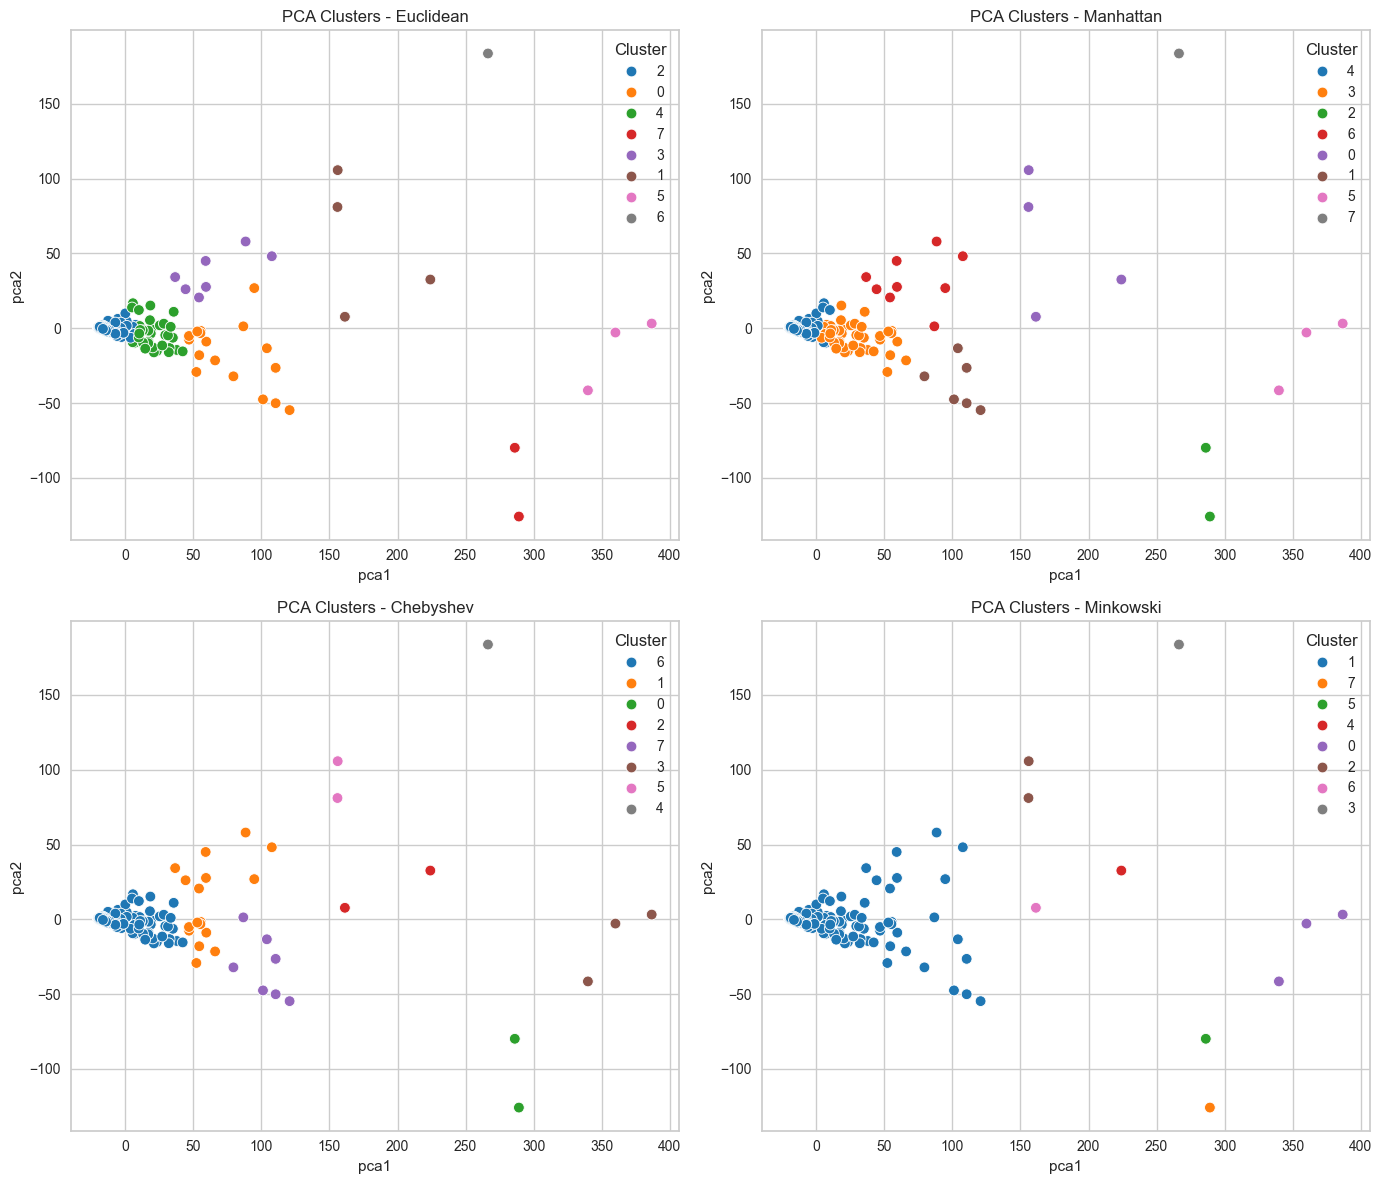

In [41]:
metrics_hierarchical = ["hierarchical_cluster_euclidean",
                        "hierarchical_cluster_manhattan",
                        "hierarchical_cluster_chebyshev",
                        "hierarchical_cluster_minkowski"]

# Plot PCA results
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics_hierarchical):
    sns.scatterplot(
        data=clustering_df,
        x="pca1", y="pca2",
        hue=clustering_df[metric].astype(str),
        palette="tab10",
        ax=axs[i],
        s=60
    )
    axs[i].set_title(f"PCA Clusters - {metric.replace('hierarchical_cluster_', '').capitalize()}")
    axs[i].legend(title="Cluster", loc="best")

plt.tight_layout()
plt.show()

### 6.2 Flat Clustering with fcluster (Top-Down)




In [42]:
# Generate linkage matrices for hierarchical clustering
linkage_euclidean = linkage(X, method='ward', metric='euclidean')  # Euclidean + Ward
linkage_manhattan = linkage(X, method='complete', metric='cityblock')  # Manhattan + Complete
linkage_euclidean_complete = linkage(X, method='complete', metric='euclidean')  # Chebyshev + Average
linkage_minkowski = linkage(X, method='single', metric='minkowski', )
                            #metric_params={'p': 3})  # Minkowski + Single


In [43]:
# n_clusters = 8
# Extract clusters using fcluster
clustering_df["fcluster_euclidean"] = fcluster(linkage_euclidean, t=n_clusters, criterion='maxclust')  # Euclidean
clustering_df["fcluster_manhattan"] = fcluster(linkage_manhattan, t=n_clusters, criterion='maxclust')  # Manhattan
clustering_df["fcluster_euclidean_complete"] = fcluster(linkage_euclidean_complete, t=n_clusters, criterion='maxclust')  # Chebyshev
clustering_df["fcluster_minkowski"] = fcluster(linkage_minkowski, t=n_clusters, criterion='maxclust')  # Minkowski


In [44]:
# Count clusters for each fcluster result
print("Euclidean Cluster Counts:")
print(clustering_df["fcluster_euclidean"].value_counts().sort_index())

print("\nManhattan Cluster Counts:")
print(clustering_df["fcluster_manhattan"].value_counts().sort_index())

print("\n euclidean_complete Cluster Counts:")
print(clustering_df["fcluster_euclidean_complete"].value_counts().sort_index())

print("\nMinkowski Cluster Counts:")
print(clustering_df["fcluster_minkowski"].value_counts().sort_index())


Euclidean Cluster Counts:
fcluster_euclidean
1     36
2    345
3      3
4      2
5      7
6     17
7      4
8      1
Name: count, dtype: int64

Manhattan Cluster Counts:
fcluster_manhattan
1     49
2    341
3      9
4      6
5      3
6      2
7      4
8      1
Name: count, dtype: int64

 euclidean_complete Cluster Counts:
fcluster_euclidean_complete
1    378
2      5
3     22
4      3
5      2
6      2
7      2
8      1
Name: count, dtype: int64

Minkowski Cluster Counts:
fcluster_minkowski
1      2
2    405
3      1
4      1
5      3
6      1
7      1
8      1
Name: count, dtype: int64


In [45]:
cluster_labels_fcluster = {
    "Euclidean": "fcluster_euclidean",
    "Manhattan": "fcluster_manhattan",
    "fcluster_euclidean_complete": "fcluster_euclidean_complete",
    "Minkowski": "fcluster_minkowski"
}

# Evaluate and display clustering scores
for name, col in cluster_labels_fcluster.items():
    print(f"\n--- {name} Distance ---")
    print(f"Silhouette Score: {silhouette_score(X, clustering_df[col]):.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(X, clustering_df[col]):.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X, clustering_df[col]):.4f}")



--- Euclidean Distance ---
Silhouette Score: 0.6966
Davies-Bouldin Score: 0.6539
Calinski-Harabasz Score: 950.9434

--- Manhattan Distance ---
Silhouette Score: 0.7166
Davies-Bouldin Score: 0.5876
Calinski-Harabasz Score: 1000.3279

--- fcluster_euclidean_complete Distance ---
Silhouette Score: 0.7795
Davies-Bouldin Score: 0.5333
Calinski-Harabasz Score: 673.2490

--- Minkowski Distance ---
Silhouette Score: 0.8362
Davies-Bouldin Score: 0.1834
Calinski-Harabasz Score: 186.3701



For top-down view clustering using fcluster, Euclidean with complete linkage gives the best cluster separation, while Manhattan distance offers the most compact and distinct clusters overall.

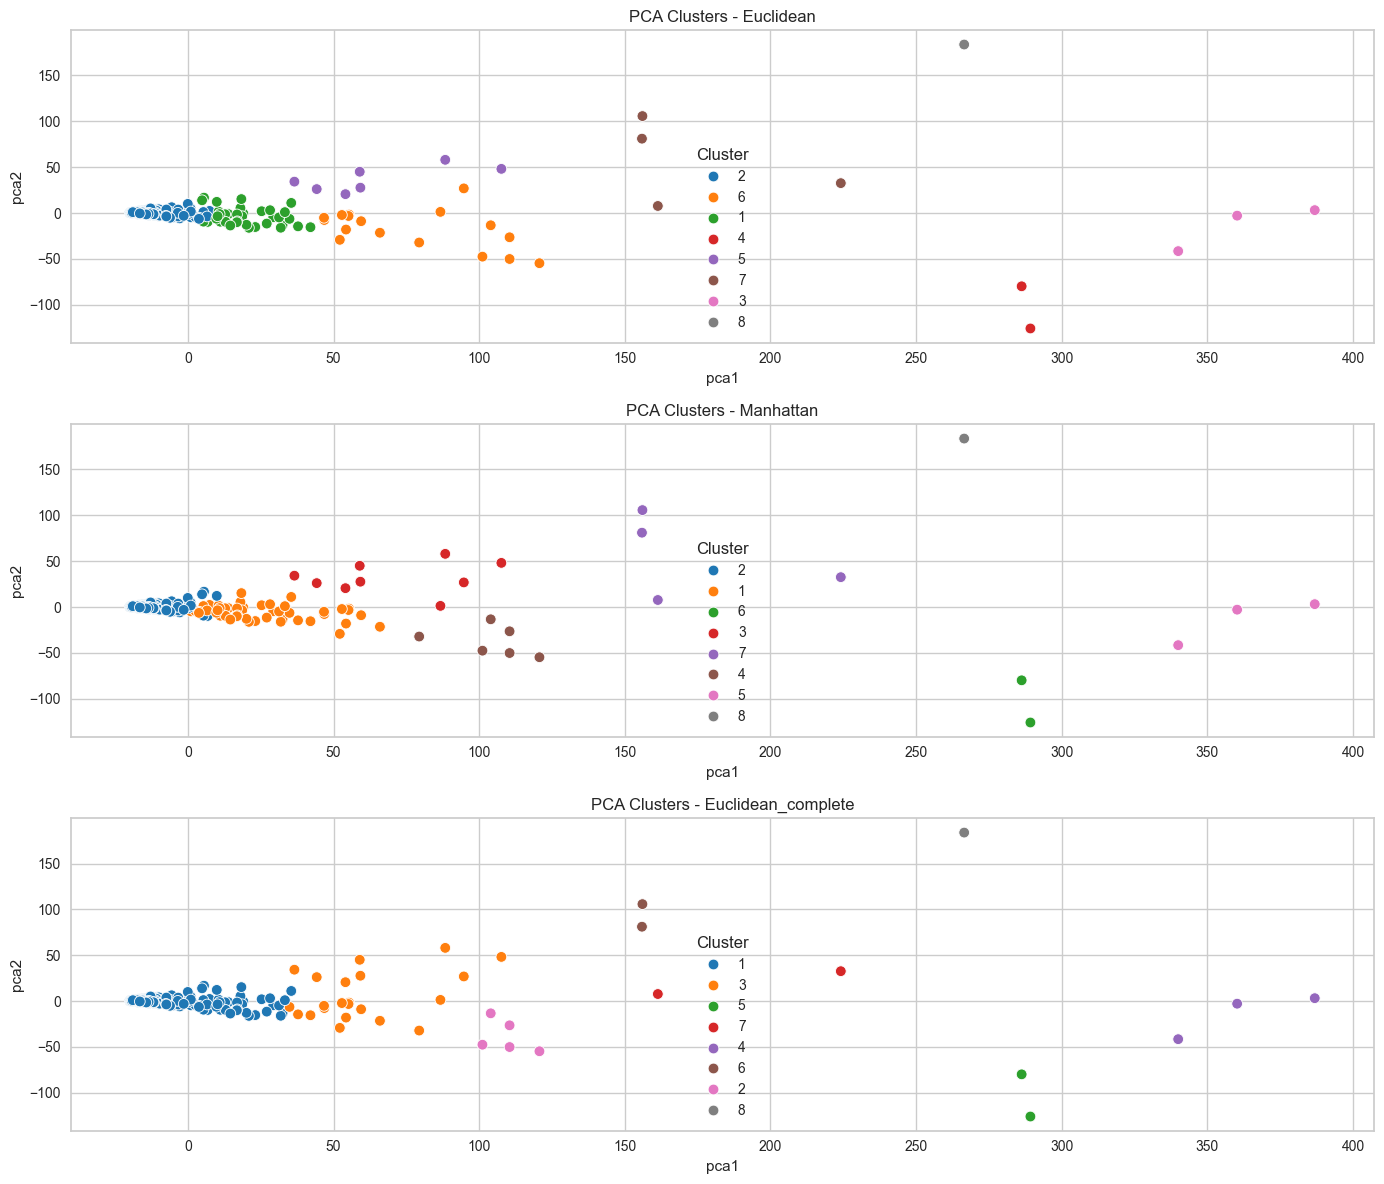

In [46]:
metrics_fcluster = ["fcluster_euclidean",
                    "fcluster_manhattan",
                    "fcluster_euclidean_complete"]


# Plot PCA results
fig, axs = plt.subplots(3, 1, figsize=(14, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics_fcluster):
    sns.scatterplot(
        data=clustering_df,
        x="pca1", y="pca2",
        hue=clustering_df[metric].astype(str),
        palette="tab10",
        ax=axs[i],
        s=60
    )
    axs[i].set_title(f"PCA Clusters - {metric.replace('fcluster_', '').capitalize()}")
    axs[i].legend(title="Cluster", loc="best")

plt.tight_layout()
plt.show()


### 6.3 Dendrograms

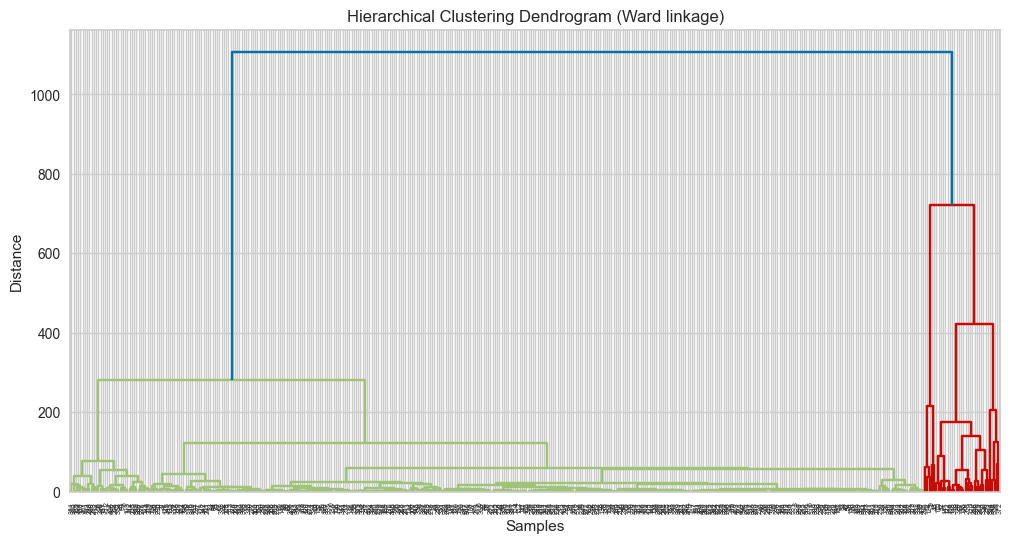

In [47]:
# Compute the linkage matrix
linkage_matrix = sch.linkage(clustering_df[num_features1], method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


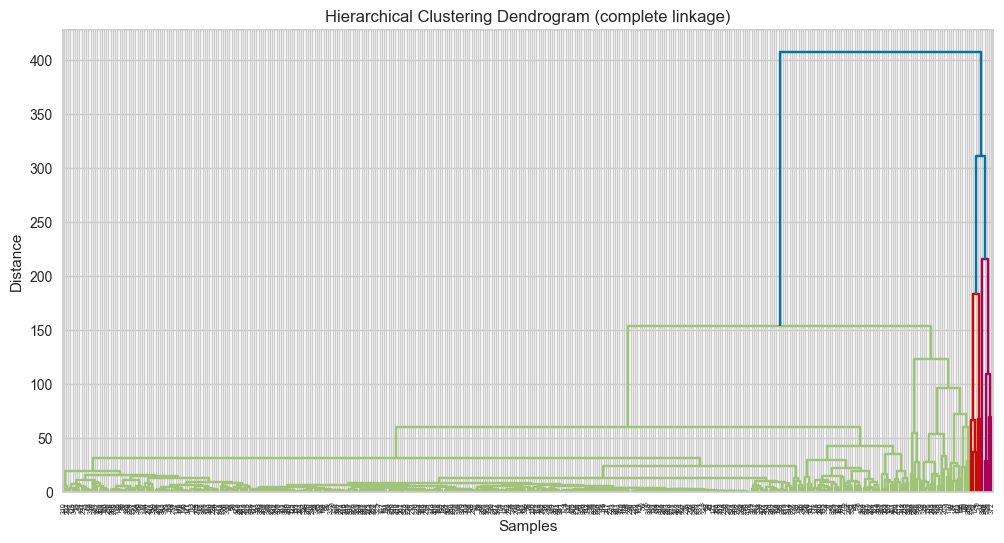

In [48]:
# Compute the linkage matrix
linkage_matrix = sch.linkage(clustering_df[num_features1], method='complete')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (complete linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


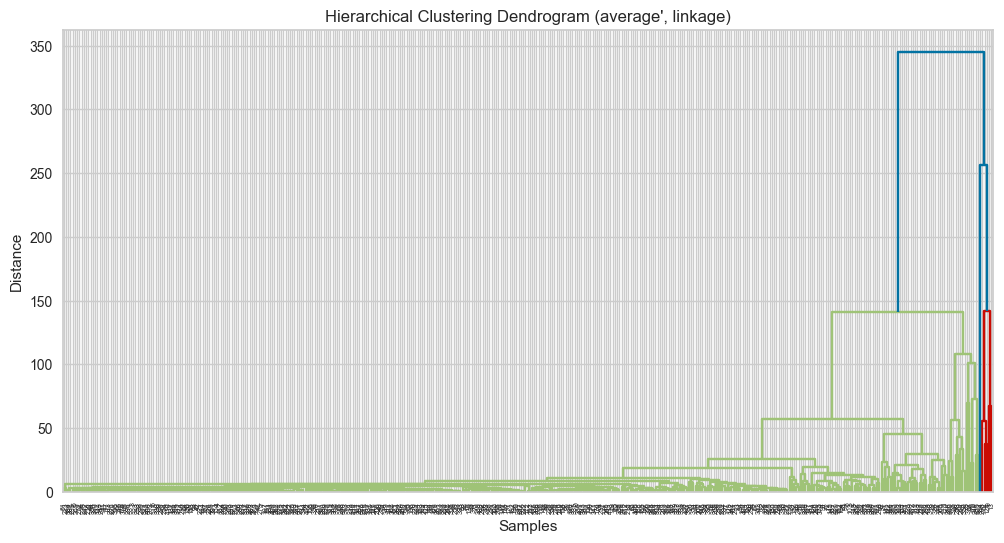

In [49]:
# Compute the linkage matrix
linkage_matrix = sch.linkage(clustering_df[num_features1], method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (average', linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


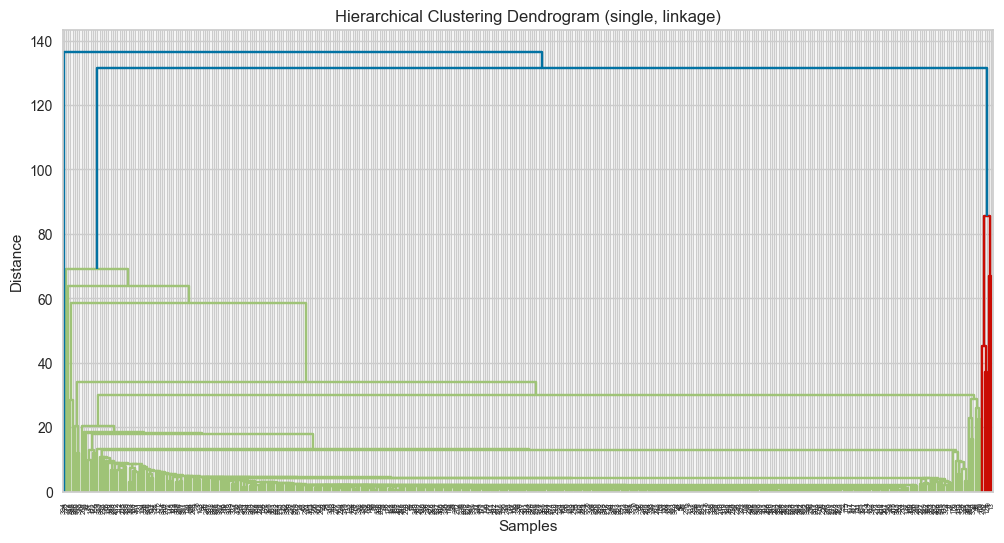

In [50]:
# Compute the linkage matrix
linkage_matrix = sch.linkage(clustering_df[num_features1], method='single')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (single, linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


## 7. Cluster Analysis

### 7.1 Cluster Feature Summary (K = 8)


In [51]:
clustering_df.head()

gnrc_name  unique_strength_count  total_unique_mftr  \
0             abacavir sulfate                      1          -0.714286   
1  abacavir sulfate/lamivudine                      1          -0.857143   
2          abiraterone acetate                      1           0.214286   
3          acamprosate calcium                      1          -0.785714   
4                     acarbose                      3          -0.928571   

   min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0          0.428450          5.081903           1.803262          1.280726   
1          2.837262         86.001593          15.261870         13.282889   
2          3.168927         29.992580          12.788470          6.311937   
3          0.127410          0.975534           0.560315          0.198422   
4         -0.189023          0.389429           0.038095          0.131510   

   min_spending  max_spending  mean_spending  ...  optimized_kmeans_euclidean  \
0     -0.446660     -0.427158      -0.437531  ...                           0   
1     -0.429567     -0.367248      -0.405265  ...                           3   
2      3.041556      3.612366       3.289946  ...                           4   
3     -0.455561     -0.445113      -0.450072  ...                           0   
4     -0.443435     -0.429197      -0.436068  ...                           0   

   optimized_kmeans_manhattan  hierarchical_cluster_euclidean  \
0                           0                               2   
1                           1                               0   
2                           1                               4   
3                           0                               2   
4                           0                               2   

   hierarchical_cluster_manhattan  hierarchical_cluster_chebyshev  \
0                               4                               6   
1                               3                               1   
2                               3                               6   
3                               4                               6   
4                               4                               6   

   hierarchical_cluster_minkowski  fcluster_euclidean  fcluster_manhattan  \
0                               1                   2                   2   
1                               1                   6                   1   
2                               1                   1                   1   
3                               1                   2                   2   
4                               1                   2                   2   

   fcluster_euclidean_complete  fcluster_minkowski  
0                            1                   2  
1                            3                   2  
2                            1                   2  
3                            1                   2  
4                            1                   2  

[5 rows x 40 columns]

### 7.2 Correlation Insights


In [52]:
numeric_columns = clustering_df.select_dtypes(include=['number']).columns

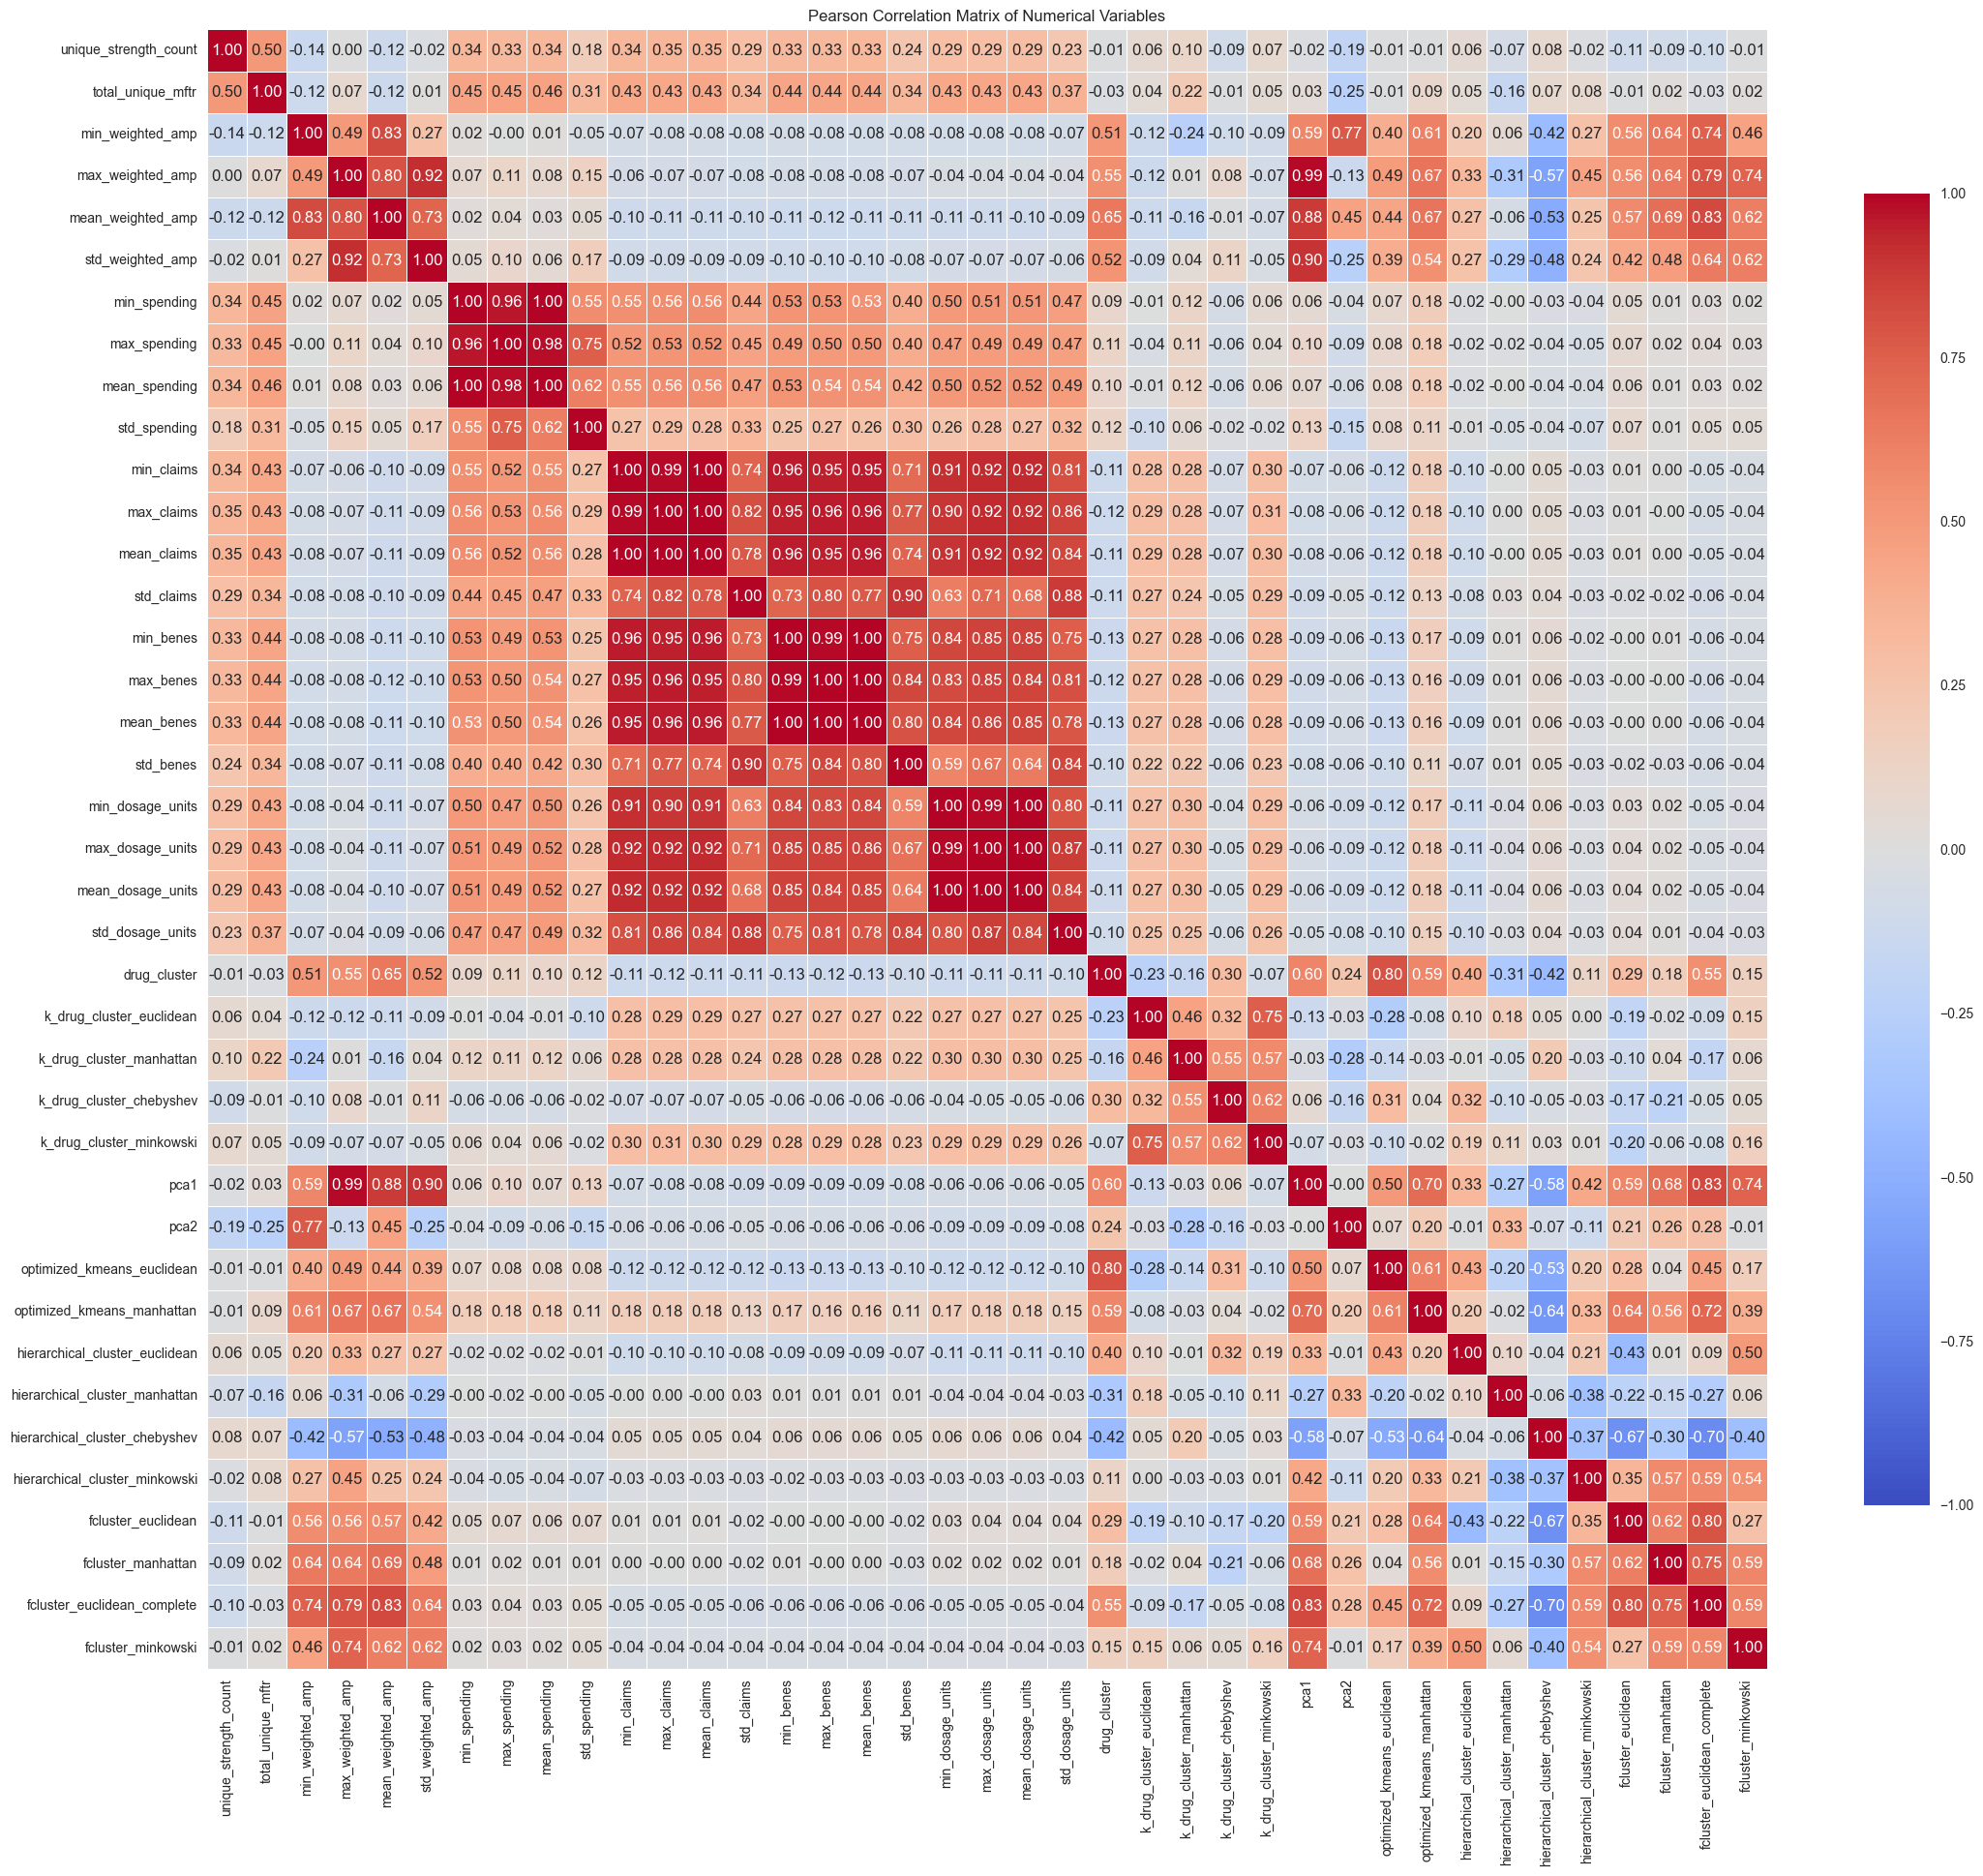

In [53]:
# Calculate Pearson correlation matrix
pearson_corr_matrix = clustering_df[numeric_columns].corr(method="pearson")

plt.figure(figsize=(26, 22))

sns.heatmap(
    pearson_corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
)

plt.title("Pearson Correlation Matrix of Numerical Variables")
plt.show()


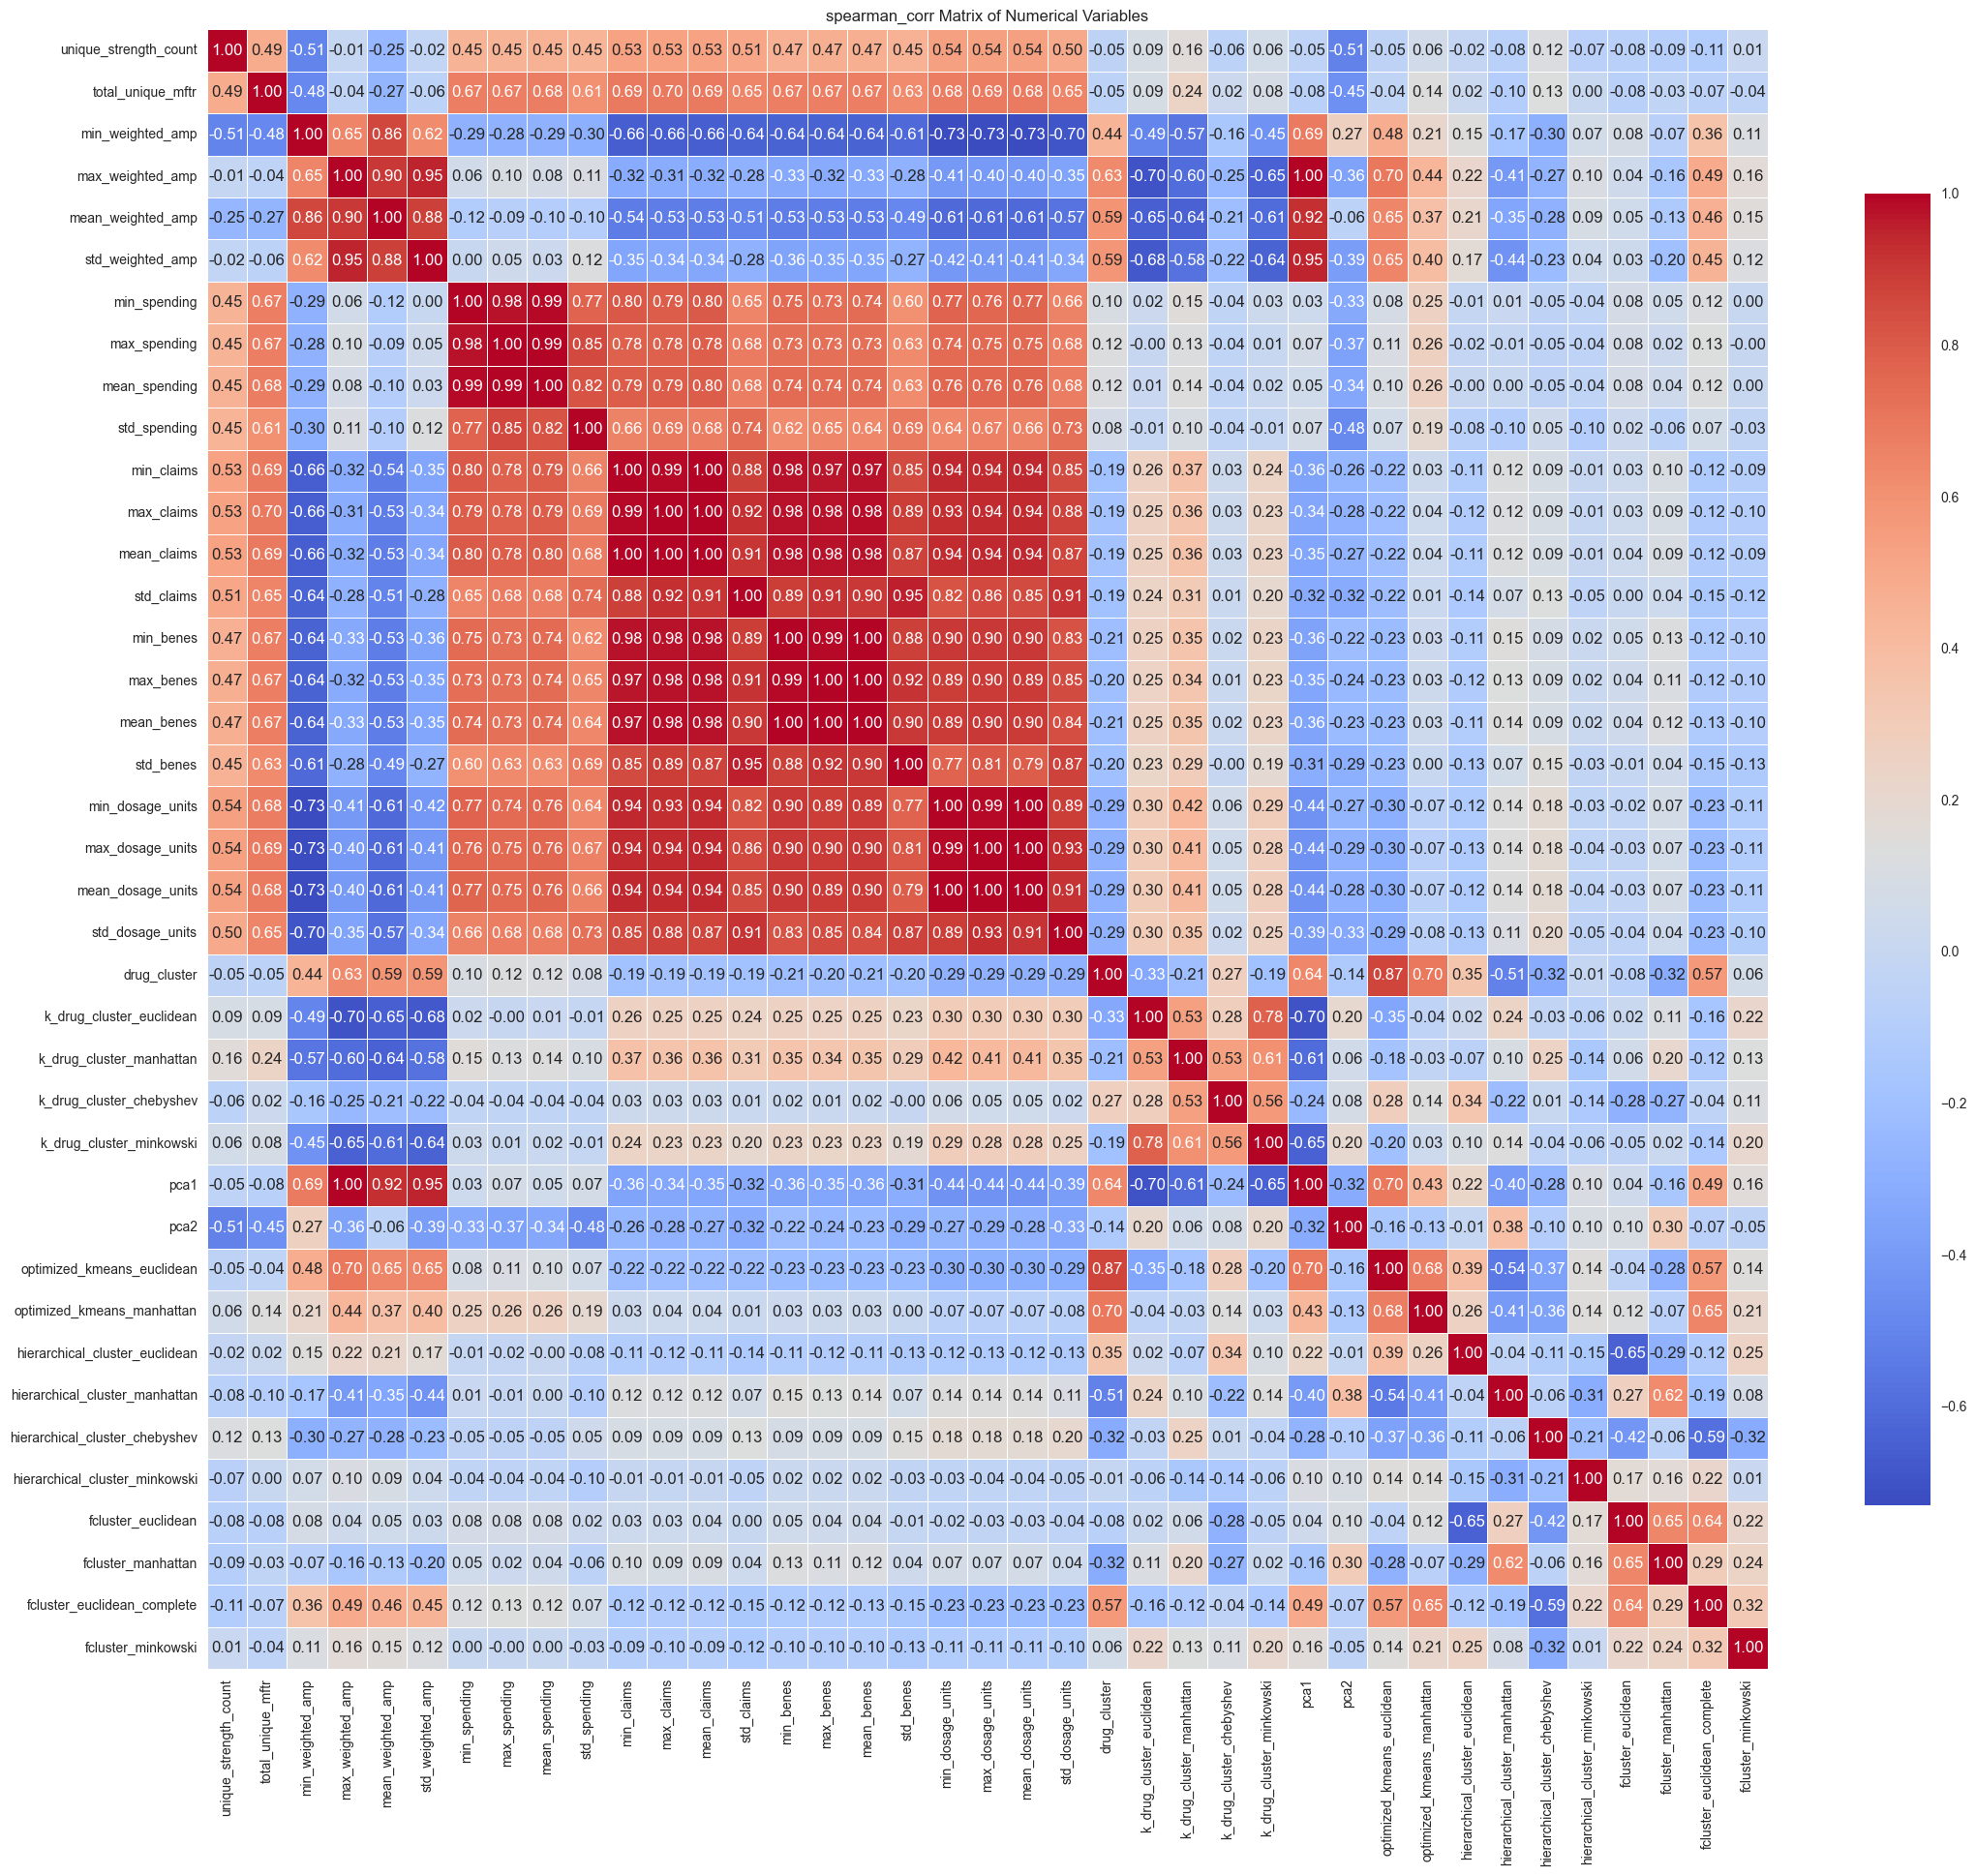

In [54]:
# Calculate Spearman correlation matrix
spearman_corr = clustering_df[numeric_columns].corr(method="spearman")

plt.figure(figsize=(26, 22))

sns.heatmap(
    spearman_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

plt.title("spearman_corr Matrix of Numerical Variables")
plt.show()

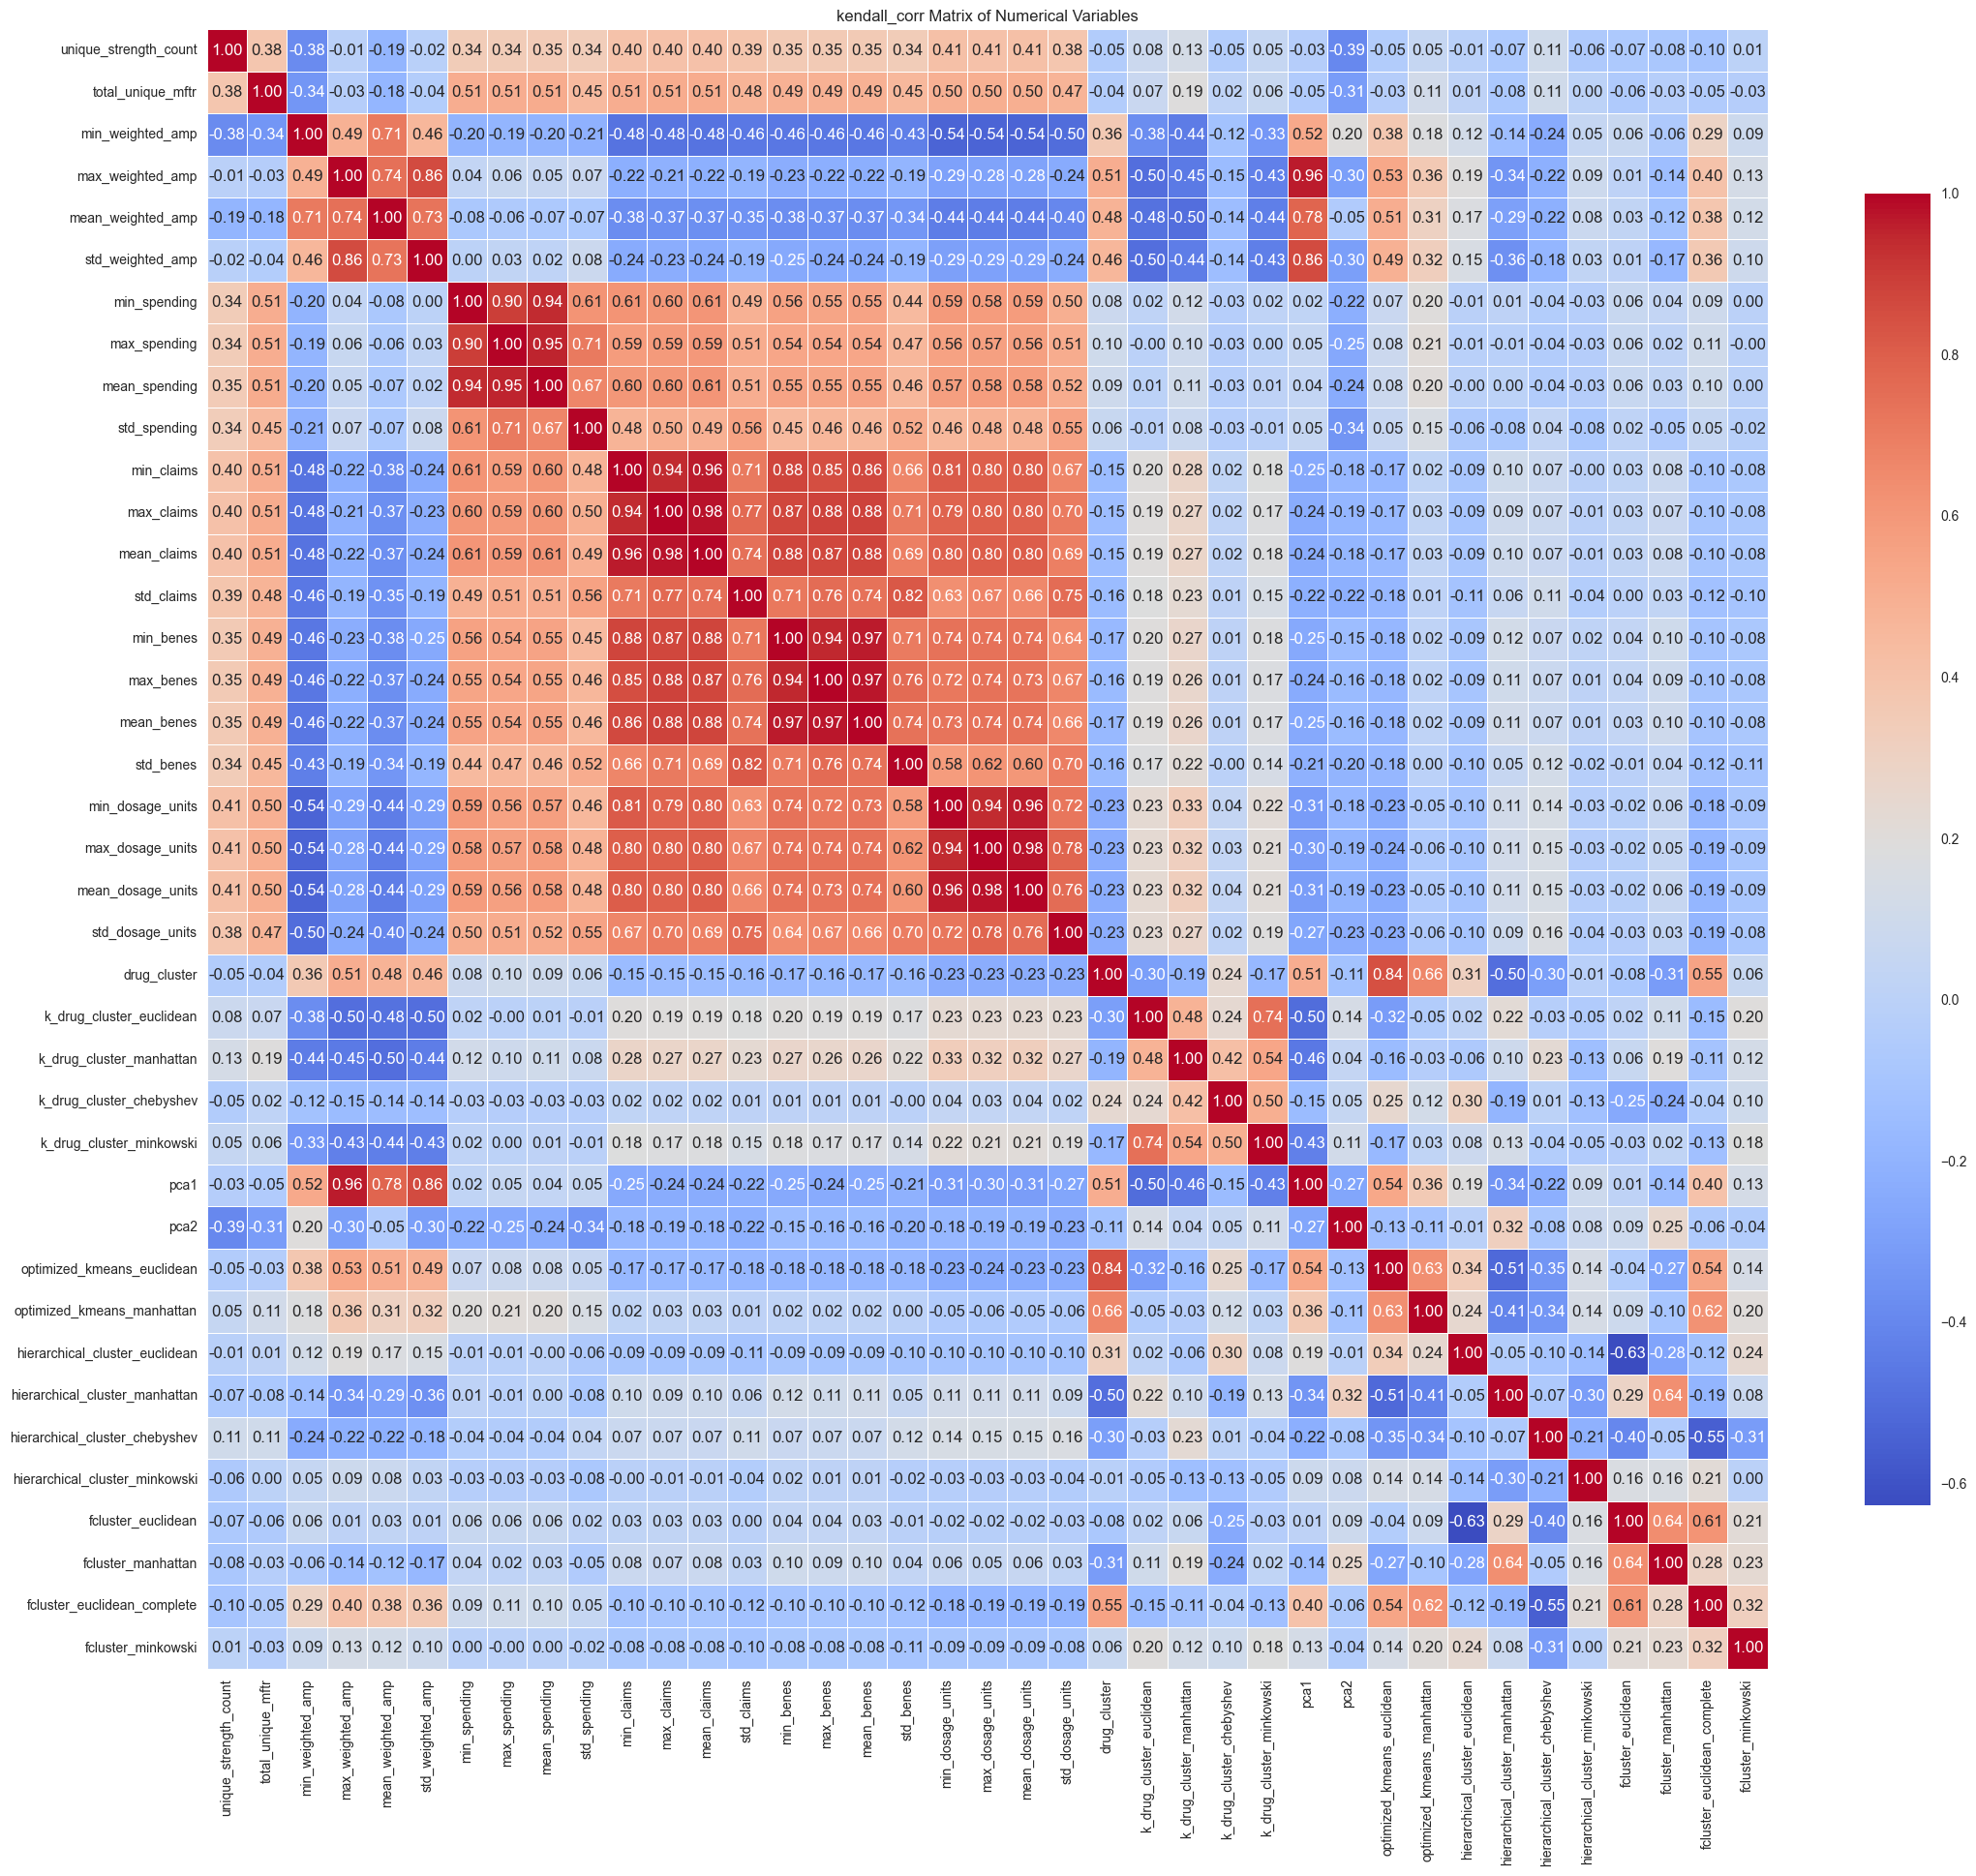

In [55]:
# Calculate Kendall correlation matrix
kendall_corr = clustering_df[numeric_columns].corr(method="kendall")

plt.figure(figsize=(26, 22))
sns.heatmap(
    kendall_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

plt.title("kendall_corr Matrix of Numerical Variables")
plt.show()

**Why k_drug_cluster_manhattan is the Best Clustering Choice**

- **Strong Correlation with Key Features:** k_drug_cluster_manhattan shows moderate to strong correlations (≥ |0.2|) across multiple features, outperforming other clustering methods in capturing meaningful relationships.

- **Robust to Outliers and Non-Linearities:** Unlike Euclidean-based clustering, Manhattan distance handles skewed distributions effectively, making it ideal for healthcare datasets with extreme values in spending and claims.

- **Reflects Real-World Drug Pricing and Utilization Patterns:** The clusters align with important industry metrics like **mean_claims, mean_spending, total_unique_mftr,** ensuring that the segmentation represents financial, usage, and manufacturing impact.

- **Interpretable and Reliable:** k_drug_cluster_manhattan balances domain relevance with statistical precision, providing stable clusters that are **well-suited for decision-making in pharmaceutical pricing and resource allocation.**

The Manhattan distance-based clustering method is the most practical and insightful choice for this dataset—offering stability, interpretability, and alignment with real-world healthcare economics.

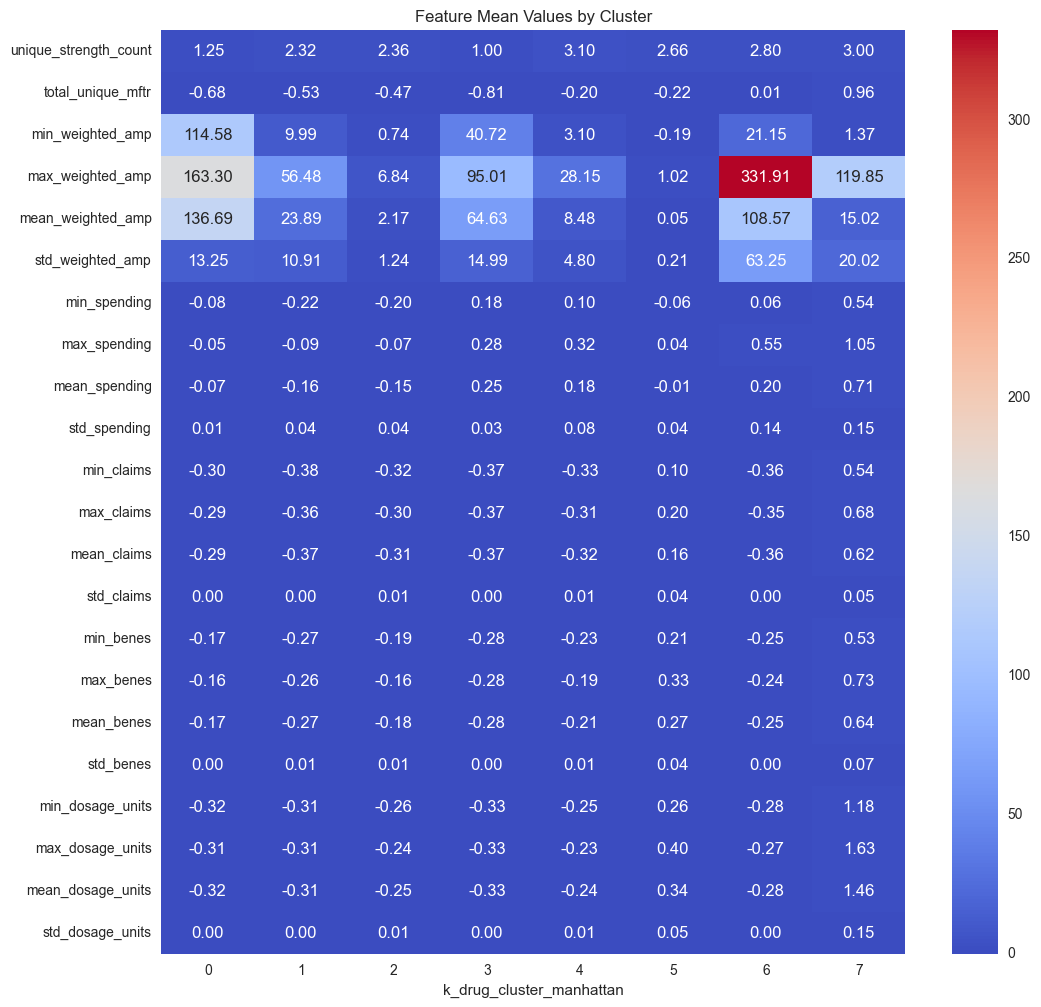

In [56]:
numeric_columns = clustering_df.select_dtypes(include=['number']).columns

cluster_means = clustering_df.groupby('k_drug_cluster_manhattan')[num_features1].mean()

plt.figure(figsize=(12, 12))
sns.heatmap(cluster_means.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Mean Values by Cluster")
plt.show()


In [57]:
cluster_means

unique_strength_count  total_unique_mftr  \
k_drug_cluster_manhattan                                             
0                                      1.250000          -0.678571   
1                                      2.318182          -0.532468   
2                                      2.362416          -0.466443   
3                                      1.000000          -0.809524   
4                                      3.095238          -0.202381   
5                                      2.661111          -0.217857   
6                                      2.800000           0.014286   
7                                      3.000000           0.959184   

                          min_weighted_amp  max_weighted_amp  \
k_drug_cluster_manhattan                                       
0                               114.578022        163.302602   
1                                 9.985593         56.482585   
2                                 0.735384          6.841391   
3                                40.717207         95.006456   
4                                 3.102765         28.145444   
5                                -0.189701          1.019674   
6                                21.148406        331.912116   
7                                 1.365313        119.848800   

                          mean_weighted_amp  std_weighted_amp  min_spending  \
k_drug_cluster_manhattan                                                      
0                                136.694284         13.249680     -0.080464   
1                                 23.888211         10.912833     -0.216279   
2                                  2.171345          1.235471     -0.198250   
3                                 64.632802         14.986621      0.183438   
4                                  8.483625          4.801565      0.100839   
5                                  0.054711          0.210052     -0.064188   
6                                108.574241         63.248156      0.063402   
7                                 15.016681         20.015192      0.541289   

                          max_spending  mean_spending  std_spending  ...  \
k_drug_cluster_manhattan                                             ...   
0                            -0.050598      -0.070673      0.014021  ...   
1                            -0.090074      -0.157571      0.043375  ...   
2                            -0.072489      -0.152993      0.043212  ...   
3                             0.280502       0.247189      0.034309  ...   
4                             0.320539       0.176568      0.076326  ...   
5                             0.044763      -0.011151      0.039008  ...   
6                             0.545263       0.198276      0.142255  ...   
7                             1.054252       0.708341      0.150749  ...   

                          mean_claims  std_claims  min_benes  max_benes  \
k_drug_cluster_manhattan                                                  
0                           -0.294020    0.002490  -0.170609  -0.162379   
1                           -0.371256    0.004657  -0.273344  -0.259086   
2                           -0.307222    0.007884  -0.191351  -0.160654   
3                           -0.370719    0.000630  -0.278155  -0.276919   
4                           -0.316119    0.006856  -0.225218  -0.187925   
5                            0.155121    0.037250   0.214604   0.329055   
6                           -0.356306    0.001684  -0.247497  -0.242736   
7                            0.622450    0.046323   0.527703   0.726291   

                          mean_benes  std_benes  min_dosage_units  \
k_drug_cluster_manhattan                                            
0                          -0.168114   0.003803         -0.315202   
1                          -0.266798   0.005007         -0.313218   
2                          -0.176325   0.011316         -0.257895   
3                          -0.277477

In [58]:
clustering_df["k_drug_cluster_manhattan"].value_counts().sort_index()

k_drug_cluster_manhattan
0      4
1     22
2    149
3      6
4     42
5    180
6      5
7      7
Name: count, dtype: int64

In [59]:
# Sample 5 drug names per cluster
cluster_samples = []
for cluster in sorted(clustering_df['k_drug_cluster_manhattan'].unique()):
    sample_drugs = clustering_df[clustering_df['k_drug_cluster_manhattan'] == cluster]['gnrc_name'].head(5).tolist()
    for i, drug in enumerate(sample_drugs):
        cluster_samples.append({'Cluster': cluster, 'Example Drug': drug, 'Sample #': i + 1})


sample_df = pd.DataFrame(cluster_samples)
table_summary = sample_df.pivot(index='Sample #', columns='Cluster', values='Example Drug')
table_summary

Cluster                       0                            1  \
Sample #                                                       
1                    aprepitant  abacavir sulfate/lamivudine   
2         loteprednol etabonate           atazanavir sulfate   
3               timolol maleate   ciprofloxacin hcl/dexameth   
4                    travoprost                    clonidine   
5                           NaN                difluprednate   

Cluster                               2                          3  \
Sample #                                                             
1                      abacavir sulfate         adefovir dipivoxil   
2                             adapalene                bimatoprost   
3                     albuterol sulfate               brinzolamide   
4            alclometasone dipropionate                deferasirox   
5         amlodipine bes/olmesartan med  naproxen/esomeprazole mag   

Cluster                            4                           5  \
Sample #                                                           
1                abiraterone acetate         acamprosate calcium   
2                          acitretin                    acarbose   
3         adapalene/benzoyl peroxide               acetaminophen   
4                        armodafinil  acetaminophen with codeine   
5                  asenapine maleate               acetazolamide   

Cluster                            6                         7  
Sample #                                                        
1                          acyclovir                budesonide  
2                        albendazole             metformin hcl  
3                      buprenorphine  methylergonovine maleate  
4         dihydroergotamine mesylate      metoprolol succinate  
5                  imatinib mesylate        risedronate sodium

In [60]:
clustering_df[['gnrc_name', 'drug_cluster']]

gnrc_name  drug_cluster
0               abacavir sulfate             1
1    abacavir sulfate/lamivudine             2
2            abiraterone acetate             4
3            acamprosate calcium             1
4                       acarbose             1
..                           ...           ...
410                   zidovudine             1
411                     zileuton             4
412                 zolmitriptan             4
413            zolpidem tartrate             1
414                   zonisamide             1

[415 rows x 2 columns]

### 7.3 Assigning Cluster Labels to Original Data


In [61]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gnrc_name                       415 non-null    object 
 1   unique_strength_count           415 non-null    int64  
 2   total_unique_mftr               415 non-null    float64
 3   min_weighted_amp                415 non-null    float64
 4   max_weighted_amp                415 non-null    float64
 5   mean_weighted_amp               415 non-null    float64
 6   std_weighted_amp                415 non-null    float64
 7   min_spending                    415 non-null    float64
 8   max_spending                    415 non-null    float64
 9   mean_spending                   415 non-null    float64
 10  std_spending                    415 non-null    float64
 11  min_claims                      415 non-null    float64
 12  max_claims                      415 

In [62]:
# Merge clustering_df with eda_data2 on the unique identifier column
merged_data = pd.merge(eda_data2, clustering_df[["gnrc_name", "k_drug_cluster_manhattan"]],
                       on="gnrc_name", how="left")

# Verify the merged data
merged_data.head()

product_group                      ingredient    strength  dosage route  \
0           3867  irbesartan/hydrochlorothiazide  150-12.5mg  tablet  oral   
1           3867  irbesartan/hydrochlorothiazide  150-12.5mg  tablet  oral   
2           3867  irbesartan/hydrochlorothiazide  150-12.5mg  tablet  oral   
3           3867  irbesartan/hydrochlorothiazide  150-12.5mg  tablet  oral   
4           3867  irbesartan/hydrochlorothiazide  150-12.5mg  tablet  oral   

  mdr_unit_type  weighted_average_of_amps   aca_ful  package_size  \
0           tab                  0.260389  0.455681          30.0   
1           tab                  0.260389  0.455681          30.0   
2           tab                  0.260389  0.455681          90.0   
3           tab                  0.260389  0.455681          30.0   
4           tab                  0.260389  0.455681          90.0   

             ndc  ...                       gnrc_name  tot_mftr   tot_spndng  \
0  00024-5855-30  ...  irbesartan/hydrochlorothiazide         8  20170502.59   
1  00054-0254-13  ...  irbesartan/hydrochlorothiazide         8  20170502.59   
2  00054-0254-22  ...  irbesartan/hydrochlorothiazide         8  20170502.59   
3  00093-8238-56  ...  irbesartan/hydrochlorothiazide         8  20170502.59   
4  00093-8238-98  ...  irbesartan/hydrochlorothiazide         8  20170502.59   

   tot_clms tot_benes  tot_dsg_unts  avg_spnd_per_dsg_unt_wghtd  \
0  592499.0  145787.0    44197753.0                      4.5255   
1  592499.0  145787.0    44197753.0                      4.5255   
2  592499.0  145787.0    44197753.0                      4.5255   
3  592499.0  145787.0    44197753.0                      4.5255   
4  592499.0  145787.0    44197753.0                      4.5255   

   avg_spnd_per_clm  avg_spnd_per_bene  k_drug_cluster_manhattan  
0             312.2            1318.07                         2  
1             312.2            1318.07                         2  
2             312.2            1318.07                         2  
3             312.2            1318.07                         2  
4             312.2            1318.07                         2  

[5 rows x 24 columns]

In [63]:
# Get current working directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Path to the existing processed folder in repo root
processed_path = os.path.join(repo_root, "data", "processed")

# Ensure the folder exists
os.makedirs(processed_path, exist_ok=True)

# Full path to save the clustered dataset
csv_file_path = os.path.join(processed_path, "clustered_dataset.csv")

# Save the DataFrame
merged_data.to_csv(csv_file_path, index=False)

print(f"Clustered dataset saved successfully at: {csv_file_path}")


Clustered dataset saved successfully at: c:\Users\shiri\OneDrive\Documents\Python\ml-projects\data-606\pharmaceutical-drug-price-prediction\data\processed\clustered_dataset.csv


In [64]:
df_model2 = eda_data2[features].dropna()

# Grouping by Drug Name
summary2 = df_model2.groupby("gnrc_name").agg(
    unique_strength_count=("strength", lambda x: x.nunique()),
    #unique_brands=("brnd_name", lambda x: x.nunique()),
    total_unique_mftr=("tot_mftr", lambda x: sum(set(x))),
    min_weighted_amp = ("weighted_average_of_amps", "min"),
    max_weighted_amp = ("weighted_average_of_amps","max"),
    mean_weighted_amp = ("weighted_average_of_amps","mean"),
    std_weighted_amp = ("weighted_average_of_amps","std"),
    min_spending=("tot_spndng", "min"),
    max_spending=("tot_spndng", "max"),
    mean_spending=("tot_spndng", "mean"),
    std_spending=("tot_spndng", "std"),
    min_claims=("tot_clms", "min"),
    max_claims=("tot_clms", "max"),
    mean_claims=("tot_clms", "mean"),
    std_claims=("tot_clms", "std"),
    min_benes=("tot_benes", "min"),
    max_benes=("tot_benes", "max"),
    mean_benes=("tot_benes", "mean"),
    std_benes=("tot_benes", "std"),
    min_dosage_units=("tot_dsg_unts", "min"),
    max_dosage_units=("tot_dsg_unts", "max"),
    mean_dosage_units=("tot_dsg_unts", "mean"),
    std_dosage_units=("tot_dsg_unts", "std"),
).reset_index()

# Display Summary
summary2

gnrc_name  unique_strength_count  total_unique_mftr  \
0               abacavir sulfate                      1                  7   
1    abacavir sulfate/lamivudine                      1                  5   
2            abiraterone acetate                      1                 20   
3            acamprosate calcium                      1                  6   
4                       acarbose                      3                  4   
..                           ...                    ...                ...   
410                   zidovudine                      1                  3   
411                     zileuton                      1                  6   
412                 zolmitriptan                      4                 15   
413            zolpidem tartrate                      4                 47   
414                   zonisamide                      3                 21   

     min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0            0.266676          1.832037           0.729145          0.430820   
1            1.076969         29.052369           5.256446          4.468191   
2            1.188537         10.211665           4.424426          2.123254   
3            0.165410          0.450708           0.311034          0.066746   
4            0.058966          0.253550           0.135366          0.044238   
..                ...               ...                ...               ...   
410          0.184692          0.251689           0.209460          0.021360   
411          2.845173         15.684571           7.348537          3.701519   
412          0.345982         15.897459           3.132441          2.094798   
413          0.013498          1.995785           0.191444          0.238222   
414          0.017752          1.119935           0.247432          0.322896   

     min_spending  max_spending  mean_spending  ...   mean_claims  \
0    7.114878e+06  1.115072e+07   9.003995e+06  ...  3.532998e+04   
1    1.065217e+07  2.354874e+07   1.568130e+07  ...  3.575473e+04   
2    7.289803e+08  8.471061e+08   7.803832e+08  ...  2.084175e+05   
3    5.272879e+06  7.435040e+06   6.408678e+06  ...  3.977312e+04   
4    7.782119e+06  1.072864e+07   9.306766e+06  ...  1.716748e+05   
..            ...           ...            ...  ...           ...   
410  4.445768e+05  4.445768e+05   4.445768e+05  ...  1.012700e+04   
411  1.759024e+07  1.968315e+07   1.881110e+07  ...  5.965000e+03   
412  1.305680e+07  1.566786e+07   1.439301e+07  ...  5.838978e+04   
413  8.994882e+07  9.934792e+07   9.581813e+07  ...  7.669864e+06   
414  3.359846e+07  4.036280e+07   3.668531e+07  ...  3.869428e+05   

        std_claims  min_benes  max_benes    mean_benes     std_benes  \
0      6816.906541     3497.0     7531.0  5.281587e+03   1387.787101   
1      9628.818299     3532.0     9829.0  5.787310e+03   2143.539341   
2     20768.980785    29515.0    36641.0  3.272702e+04   2880.684113   
3      3888.217728    10706.0    13739.0  1.211826e+04   1086.818439   
4     10541.754855    42897.0    44200.0  4.356314e+04    554.326986   
..             ...        ...        ...           ...           ...   
410       0.000000     1509.0     1509.0  1.509000e+03      0.000000   
411     428.946958      941.0     1105.0  1.036667e+03     81.420487   
412    3855.540625    14060.0    15604.0  1.510345e+04    457.622970   
413  162179.351308  1484983.0  1606958.0  1.521410e+06  48369.942436   
414    6744.611690    62733.0    69095.0  6.547841e+04   2325.777353   

     min_dosage_units  max_dosage_units  mean_dosage_units  std_dosage_units  
0           2073998.0         3413571.0       2.869378e+06      4.982527e+05  
1           1011910.0         1610782.0       1.252579e+06      2.420717e+05  
2          19548320.0        24581582.0       2.190076e+07      2.041389e+06  
3           5536265.0         7604129.0       6.579157e+06      7.550509e+05  
4          22122226.0        2896775

In [65]:
clustering_df2 = summary2.copy()

In [66]:
# Add the 'k_drug_cluster_manhattan' column to clustering_df2
clustering_df2["k_drug_cluster_manhattan"] = clustering_df["k_drug_cluster_manhattan"]

# Verify the result
clustering_df2.head()

gnrc_name  unique_strength_count  total_unique_mftr  \
0             abacavir sulfate                      1                  7   
1  abacavir sulfate/lamivudine                      1                  5   
2          abiraterone acetate                      1                 20   
3          acamprosate calcium                      1                  6   
4                     acarbose                      3                  4   

   min_weighted_amp  max_weighted_amp  mean_weighted_amp  std_weighted_amp  \
0          0.266676          1.832037           0.729145          0.430820   
1          1.076969         29.052369           5.256446          4.468191   
2          1.188537         10.211665           4.424426          2.123254   
3          0.165410          0.450708           0.311034          0.066746   
4          0.058966          0.253550           0.135366          0.044238   

   min_spending  max_spending  mean_spending  ...    std_claims  min_benes  \
0  7.114878e+06  1.115072e+07   9.003995e+06  ...   6816.906541     3497.0   
1  1.065217e+07  2.354874e+07   1.568130e+07  ...   9628.818299     3532.0   
2  7.289803e+08  8.471061e+08   7.803832e+08  ...  20768.980785    29515.0   
3  5.272879e+06  7.435040e+06   6.408678e+06  ...   3888.217728    10706.0   
4  7.782119e+06  1.072864e+07   9.306766e+06  ...  10541.754855    42897.0   

   max_benes    mean_benes    std_benes  min_dosage_units  max_dosage_units  \
0     7531.0   5281.587264  1387.787101         2073998.0         3413571.0   
1     9829.0   5787.309524  2143.539341         1011910.0         1610782.0   
2    36641.0  32727.016627  2880.684113        19548320.0        24581582.0   
3    13739.0  12118.256724  1086.818439         5536265.0         7604129.0   
4    44200.0  43563.142968   554.326986        22122226.0        28967752.0   

   mean_dosage_units  std_dosage_units  k_drug_cluster_manhattan  
0       2.869378e+06      4.982527e+05                         2  
1       1.252579e+06      2.420717e+05                         1  
2       2.190076e+07      2.041389e+06                         4  
3       6.579157e+06      7.550509e+05                         5  
4       2.595308e+07      2.889078e+06                         5  

[5 rows x 24 columns]

In [67]:
# Group actual data by clusters and calculate ranges
cluster_ranges = clustering_df2.groupby("k_drug_cluster_manhattan").agg({
    'mean_weighted_amp': ['min', 'max', 'mean'],
    'total_unique_mftr': ['min', 'max', 'mean'],
    'mean_claims': ['min', 'max', 'mean'],
    'mean_benes': ['min', 'max', 'mean']
})

# Rename columns for better readability
cluster_ranges.columns = ['AMP_min', 'AMP_max', 'AMP_mean',
                          'MFTR_min', 'MFTR_max', 'MFTR_mean',
                          'Claims_min', 'Claims_max', 'Claims_mean',
                          'Benes_min', 'Benes_max', 'Benes_mean']

# Display the cluster ranges
cluster_ranges

AMP_min    AMP_max   AMP_mean  MFTR_min  MFTR_max  \
k_drug_cluster_manhattan                                                        
0                         37.715628  66.530466  46.104731         5        12   
1                          3.499957  15.573794   8.158235         3        97   
2                          0.127991   4.234354   0.852963         2        99   
3                         15.255417  30.510096  21.864185         3        18   
4                          0.241690   8.198561   2.976332         2        79   
5                          0.003816   0.486982   0.140955         1        92   
6                          1.694258  58.846240  36.645514         7        71   
7                          0.359760  14.616501   5.173967         4        81   

                          MFTR_mean   Claims_min    Claims_max   Claims_mean  \
k_drug_cluster_manhattan                                                       
0                          7.500000  9549.039301  2.864936e+06  9.707291e+05   
1                         11.863636   267.833333  3.607097e+06  3.401009e+05   
2                         13.892617   265.485517  1.636597e+07  8.629398e+05   
3                          8.500000  5303.937500  1.733009e+06  3.444911e+05   
4                         15.380952   347.000000  8.882981e+06  7.902982e+05   
5                         16.877778   110.691845  5.894783e+07  4.637962e+06   
6                         24.000000  7789.768595  1.846653e+06  4.621703e+05   
7                         37.714286   200.294737  3.165728e+07  8.453691e+06   

                            Benes_min     Benes_max    Benes_mean  
k_drug_cluster_manhattan                                           
0                         4076.882096  7.870318e+05  3.169347e+05  
1                           68.509804  1.216855e+06  1.069340e+05  
2                           76.831724  6.454116e+06  2.994596e+05  
3                          721.000000  3.962774e+05  8.421084e+04  
4                          179.000000  3.085908e+06  2.307602e+05  
5                           30.478112  1.417345e+07  1.255904e+06  
6                         4513.525773  6.742636e+05  1.530391e+05  
7                          110.331579  7.787075e+06  2.037615e+06

## 8. Clusters Dashboards

In [68]:
import plotly.graph_objects as go
import plotly.io as pio

# Use browser renderer in VS Code
pio.renderers.default = "browser"


In [69]:
# Function to create cluster dashboard
def create_cluster_dashboard(cluster_df, cluster_num):
    stats = {
        "AMP": {
            "min": cluster_df["mean_weighted_amp"].min(),
            "avg": cluster_df["mean_weighted_amp"].mean(),
            "max": cluster_df["mean_weighted_amp"].max(),
        },
        "Claims": {
            "min": cluster_df["mean_claims"].min(),
            "avg": cluster_df["mean_claims"].mean(),
            "max": cluster_df["mean_claims"].max(),
        },
        "Beneficiaries": {
            "min": cluster_df["mean_benes"].min(),
            "avg": cluster_df["mean_benes"].mean(),
            "max": cluster_df["mean_benes"].max(),
        },
        "Manufacturers": {
            "min": cluster_df["total_unique_mftr"].min(),
            "total": cluster_df["total_unique_mftr"].sum(),
            "max": cluster_df["total_unique_mftr"].max(),
        },
    }

    fig = go.Figure()
    row_map = {"AMP": 0, "Claims": 1, "Beneficiaries": 2, "Manufacturers": 3}
    col_map = {
        "min": 0,
        "avg": 1,
        "max": 2,
        "total": 1,
    }  # 'total' in center for Manufacturers

    for metric, values in stats.items():
        for key, val in values.items():
            fig.add_trace(
                go.Indicator(
                    mode="number",
                    value=val,
                    title={
                        "text": f"<b>{key} {metric}</b>",
                        "font": {"size": 16, "color": "darkblue"},
                    },
                    number={"font": {"size": 28, "color": "purple"}},
                    domain={"row": row_map[metric], "column": col_map[key]},
                )
            )

    fig.update_layout(
        grid={"rows": 4, "columns": 3, "pattern": "independent"},
        title={
            "text": f"<b>Cluster {cluster_num} Dashboard</b>",
            "font": {"size": 24, "color": "black"},
        },
        height=800,
    )

    fig.show()


# Generate dashboards for all clusters
unique_clusters = clustering_df2["k_drug_cluster_manhattan"].unique()
for cluster in unique_clusters:
    cluster_data = clustering_df2[clustering_df2["k_drug_cluster_manhattan"] == cluster]
    create_cluster_dashboard(cluster_data, cluster)


In [70]:
# Loop through all clusters and print top 5 drugs
unique_clusters = clustering_df2["k_drug_cluster_manhattan"].unique()

for cluster in unique_clusters:
    cluster_data = clustering_df2[clustering_df2["k_drug_cluster_manhattan"] == cluster]
    top_drugs = cluster_data["gnrc_name"].head(5).tolist()

    print(f"\nTop 5 Drugs in Cluster {cluster}:")
    for i, drug in enumerate(top_drugs, 1):
        print(f"{i}. {drug}")



Top 5 Drugs in Cluster 2:
1. abacavir sulfate
2. adapalene
3. albuterol sulfate
4. alclometasone dipropionate
5. amlodipine bes/olmesartan med

Top 5 Drugs in Cluster 1:
1. abacavir sulfate/lamivudine
2. atazanavir sulfate
3. ciprofloxacin hcl/dexameth
4. clonidine
5. difluprednate

Top 5 Drugs in Cluster 4:
1. abiraterone acetate
2. acitretin
3. adapalene/benzoyl peroxide
4. armodafinil
5. asenapine maleate

Top 5 Drugs in Cluster 5:
1. acamprosate calcium
2. acarbose
3. acetaminophen
4. acetaminophen with codeine
5. acetazolamide

Top 5 Drugs in Cluster 6:
1. acyclovir
2. albendazole
3. buprenorphine
4. dihydroergotamine mesylate
5. imatinib mesylate

Top 5 Drugs in Cluster 3:
1. adefovir dipivoxil
2. bimatoprost
3. brinzolamide
4. deferasirox
5. naproxen/esomeprazole mag

Top 5 Drugs in Cluster 0:
1. aprepitant
2. loteprednol etabonate
3. timolol maleate
4. travoprost

Top 5 Drugs in Cluster 7:
1. budesonide
2. metformin hcl
3. methylergonovine maleate
4. metoprolol succinate
5. ri

Drug Clusters Summary

Cluster 0 – Moderate AMP Balanced Users
Moderately priced drugs (~$37–$66) with strong usage but fewer manufacturers. Stable demand, yet supply chain disruptions could pose risks.

Cluster 1 – Low-Cost, High-Competition Generics
Affordable drugs (~$8) with extremely high claims and beneficiary counts. Backed by many manufacturers (up to 97), making them resilient to shortages.

Cluster 2 – Critical Ultra-Cheap Essentials
Essential drugs (e.g., albuterol) priced under $1. Heavily used and strongly supported by multiple manufacturers. Vital to public health.

Cluster 3 – Specialty High-AMP Therapies
High-cost drugs with low usage. Likely serve rare or specific conditions. Fewer manufacturers make this group highly sensitive to supply disruptions.

Cluster 4 – Mid-Range Chronic Condition Generics
Drugs under $3 used for chronic conditions. Widely prescribed with significant public health impact. Affordable yet essential.

Cluster 5 – Ultra-Cheap Mass-Use Medications
The cheapest drugs (as low as $0.004) with the highest volume of claims. Backbone of routine care; disruptions would have widespread consequences.

Cluster 6 – Rare Disease Premium Treatments
Expensive drugs for rare conditions. Few users and claims, but essential for specific patient groups. Vulnerable due to limited manufacturer support.

Cluster 7 – Affordable Chronic Blockbusters
Low-cost, high-demand drugs (e.g., metformin) for widespread conditions like diabetes. Strong manufacturer base ensures availability.

- Clusters 2 and 5 are the most vulnerable — they're cheap, essential, and heavily used. are most vulnerable to shortages due to their essential nature and widespread use.
- Clusters 1 and 7 are more resilient — with many manufacturers and wide reach.
- High-cost clusters like 3 and 6 highlight niche drugs critical to specific populations.
This analysis can inform how we prepare for drug shortages, where we invest, and which drugs to prioritize in public health planning.

## 9. Verification and Review

In [71]:
# Filter drugs containing the word
NSAIDs = clustering_df2[clustering_df2["gnrc_name"].str.contains("ibuprofen", case=False, na=False)]

# Display the results, including cluster information
print(NSAIDs[["gnrc_name", "k_drug_cluster_manhattan"]])


                gnrc_name  k_drug_cluster_manhattan
205             ibuprofen                         5
206  ibuprofen/famotidine                         2


In [72]:
# Filter drugs containing the word "needle"
needle_drugs = clustering_df2[clustering_df2["gnrc_name"].str.contains("needle", case=False, na=False)]

# Display the results, including cluster information
print(needle_drugs[["gnrc_name", "k_drug_cluster_manhattan"]])


Empty DataFrame
Columns: [gnrc_name, k_drug_cluster_manhattan]
Index: []


In [73]:
clustering_df['gnrc_name']

0                 abacavir sulfate
1      abacavir sulfate/lamivudine
2              abiraterone acetate
3              acamprosate calcium
4                         acarbose
                  ...             
410                     zidovudine
411                       zileuton
412                   zolmitriptan
413              zolpidem tartrate
414                     zonisamide
Name: gnrc_name, Length: 415, dtype: object

In [74]:
# Define substrings for filtering
search_strings = ["insulin", "acetaminophen", "ibuprofen", "aspirin",
                  "diphenhydramine", "pseudoephedrine", "guaifenesin",
                  "dextromethorphan", "oseltamivir", "phenylephrine"]

# Filter drugs that match any of the substrings
matched_drugs = clustering_df2[clustering_df2["gnrc_name"].str.contains('|'.join(search_strings), case=False, na=False)]

# Display results
print(matched_drugs[["gnrc_name", "k_drug_cluster_manhattan"]])


                         gnrc_name  k_drug_cluster_manhattan
5                    acetaminophen                         5
6       acetaminophen with codeine                         5
54   butalb/acetaminophen/caffeine                         2
55        butalbital/acetaminophen                         4
205                      ibuprofen                         5
206           ibuprofen/famotidine                         2
307          oseltamivir phosphate                         4
312    oxycodone hcl/acetaminophen                         5


In [75]:
# List of example drugs
example_drugs = ["oseltamivir phosphate", "diclofenac", "insulin glargine", "imatinib"]

# Filter dataset for these drugs
verified_drugs = clustering_df2[clustering_df2["gnrc_name"].str.contains('|'.join(example_drugs), case=False, na=False)]

# Display their clusters
print(verified_drugs[["gnrc_name", "k_drug_cluster_manhattan"]])


                         gnrc_name  k_drug_cluster_manhattan
118           diclofenac potassium                         2
119              diclofenac sodium                         5
120  diclofenac sodium/misoprostol                         2
208              imatinib mesylate                         6
307          oseltamivir phosphate                         4


In [76]:
# Select relevant columns for metrics
metric_columns = ["min_weighted_amp", "max_weighted_amp", "mean_weighted_amp",
                  "min_spending", "max_spending", "mean_spending",
                  "min_claims", "max_claims", "mean_claims"]

# Group by cluster and calculate min, max, avg
cluster_ranges = clustering_df.groupby("k_drug_cluster_manhattan")[metric_columns].agg(["min", "max", "mean"])

# Display ranges for each cluster
cluster_ranges

min_weighted_amp                          \
                                      min         max        mean   
k_drug_cluster_manhattan                                            
0                               56.744482  197.415224  114.578022   
1                               -0.363977   36.441384    9.985593   
2                               -0.356907   10.352763    0.735384   
3                               14.625176   65.307381   40.717207   
4                               -0.311269   17.199838    3.102765   
5                               -0.354404    0.441542   -0.189701   
6                               -0.260394   55.887632   21.148406   
7                               -0.341437    7.395544    1.365313   

                         max_weighted_amp                          \
                                      min         max        mean   
k_drug_cluster_manhattan                                            
0                              123.122656  203.675704  163.302602   
1                               38.413509   86.001593   56.482585   
2                                1.709130   18.035923    6.841391   
3                               55.323743  154.453008   95.006456   
4                               15.730554   53.216117   28.145444   
5                               -0.349535    6.943553    1.019674   
6                              306.294274  356.906287  331.912116   
7                               78.612604  150.796782  119.848800   

                         mean_weighted_amp                          \
                                       min         max        mean   
k_drug_cluster_manhattan                                             
0                               111.755440  197.415224  136.694284   
1                                10.040241   45.932938   23.888211   
2                                 0.016172   12.223432    2.171345   
3                                44.986478   90.335076   64.632802   
4                                 0.354171   24.008091    8.483625   
5                                -0.352970    1.083367    0.054711   
6                                 4.672317  174.571813  108.574241   
7                                 0.705166   43.087128   15.016681   

                         min_spending  ... mean_spending min_claims            \
                                  min  ...          mean        min       max   
k_drug_cluster_manhattan               ...                                      
0                           -0.444736  ...     -0.070673  -0.411756 -0.065276   
1                           -0.480475  ...     -0.157571  -0.412885 -0.030330   
2                           -0.481027  ...     -0.152993  -0.412888  1.379136   
3                           -0.468229  ...      0.247189  -0.412500 -0.203558   
4                           -0.479490  ...      0.176568  -0.412867  0.636395   
5                           -0.481027  ...     -0.011151  -0.412902  5.932108   
6                           -0.443166  ...      0.198276  -0.412370 -0.191388   
7                           -0.478104  ...      0.708341  -0.412886  3.265032   

                                   max_claims                     mean_claims  \
                              mean        min       max      mean         min   
k_drug_cluster_manhattan                                                        
0                        -0.295575  -0.411725 -0.052286 -0.290103   -0.411740   
1                        -0.378645  -0.412870  0.069309 -0.364716   -0.412877   
2                        -0.318778  -0.412873  1.798598 -0.297022   -0.412877   
3                        -0.371540  -0.412248 -0.196077 -0.369869   -0.412260   
4                        -0.326231  -0.412867  0.711838 -0.305757   -0.412867   
5                         0.098259  -0.412892  7.527112  0.203981   -0.412896   
6                        -0.358955  -0.411885 -0.183184 -0.354369   -0.411956   
7                         0.5420

In [77]:
def verify_drug_within_range(row, cluster_ranges, metric_columns):
    cluster = row["k_drug_cluster_manhattan"]
    for metric in metric_columns:
        min_val = cluster_ranges.loc[cluster, (metric, "min")]
        max_val = cluster_ranges.loc[cluster, (metric, "max")]

        # Check if the drug's value falls within the cluster's range
        if row[metric] < min_val or row[metric] > max_val:
            return False  # Drug is outside the range
    return True  # Drug falls within the range

# Apply the verification logic to each row
clustering_df["in_range"] = clustering_df.apply(verify_drug_within_range, axis=1, cluster_ranges=cluster_ranges, metric_columns=metric_columns)

# Display drugs that don't fall within the expected range
out_of_range_drugs = clustering_df[~clustering_df["in_range"]]
print(out_of_range_drugs[["gnrc_name", "k_drug_cluster_manhattan"]])


Empty DataFrame
Columns: [gnrc_name, k_drug_cluster_manhattan]
Index: []


In [78]:
# Example random drugs to test
test_drugs = ["metformin", "naproxen", "oseltamivir", "methotrexate", "losartan/hydrochlorothiazide"]

# Filter dataset for these test drugs
test_drugs_df = clustering_df[clustering_df["gnrc_name"].str.contains('|'.join(test_drugs), case=False, na=False)]

# Verify if each drug falls within its cluster range
test_drugs_df["in_range"] = test_drugs_df.apply(verify_drug_within_range, axis=1, cluster_ranges=cluster_ranges, metric_columns=metric_columns)

# Display results for the test drugs
test_drugs_df[["gnrc_name", "k_drug_cluster_manhattan", "in_range"]]


gnrc_name  k_drug_cluster_manhattan  in_range
245   losartan/hydrochlorothiazide                         5      True
256                  metformin hcl                         7      True
261            methotrexate sodium                         5      True
281                       naproxen                         5      True
282                naproxen sodium                         5      True
283      naproxen/esomeprazole mag                         3      True
307          oseltamivir phosphate                         4      True
372  sumatriptan succ/naproxen sod                         3      True